In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

import lightgbm as lgb
import xgboost as Xgb

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import RidgeClassifierCV, Perceptron, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import NuSVC
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import accuracy_score, classification_report,f1_score,confusion_matrix,precision_score,recall_score,balanced_accuracy_score
# from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve,roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
import warnings
warnings.filterwarnings("ignore")


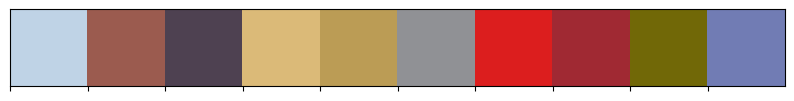

In [3]:
# Color Palettes
colors = ["#bfd3e6", "#9b5b4f", "#4e4151", "#dbba78", "#bb9c55", "#909195","#dc1e1e","#a02933","#716807","#717cb4"]
sns.palplot(sns.color_palette(colors))

In [4]:
#Default theme
sns.set_theme(palette='tab10',
              font='Comic Sans MS',
              font_scale=1.5,
              rc=None)

import matplotlib
matplotlib.rcParams.update({'font.size': 15})
plt.style.use('dark_background')
plt.rcParams["axes.grid"] = False

In [6]:
df = pd.read_csv("./data/steel_industry_data.csv")
df.head().style.background_gradient(cmap='copper').set_precision(2)

In [7]:
df.describe().T.round(2).sort_values(by='std' , ascending = False) \
                        .style.background_gradient(cmap='GnBu') \
                        .bar(subset=["max"], color='#BB0000') \
                        .bar(subset=["min",], color='green') \
                        .bar(subset=["mean",], color='Orange') \
                        .bar(subset=['std'], color='#716807') \
                        .bar(subset=['50%'], color='#717cb4')

In [8]:
corr = df.corr()
df.corr().style.background_gradient(cmap='copper').set_precision(2)

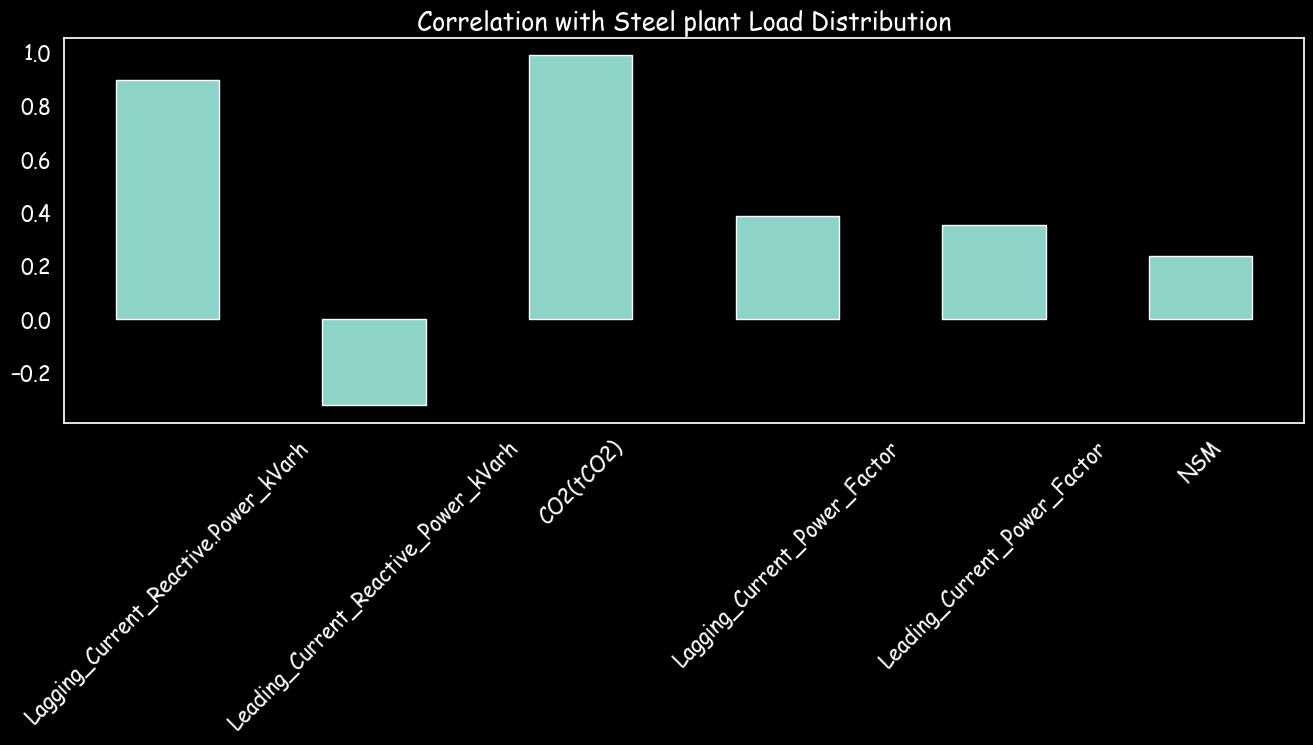

In [9]:
df1 = df.copy()
#Correlation with Response Variable class
X = df1.drop(['Usage_kWh'],axis=1)
y = df1['Usage_kWh']

X.corrwith(y).plot.bar(
        figsize = (16, 5), title = "Correlation with Steel plant Load Distribution", fontsize = 15,
        rot = 45, grid = False)
plt.show()

In [10]:
class color:
    BOLD = '\033[1m'
    END = '\033[0m'
print(f"\033[94m\033[1m")
print(color.BOLD + 'Missing values - Percentage: \n' + color.END)
print(f"\033[91m\033[1m")
print(round(df.isnull().mean() * 100, 2))


Missing values - Percentage: 


date                                    0.0
Usage_kWh                               0.0
Lagging_Current_Reactive.Power_kVarh    0.0
Leading_Current_Reactive_Power_kVarh    0.0
CO2(tCO2)                               0.0
Lagging_Current_Power_Factor            0.0
Leading_Current_Power_Factor            0.0
NSM                                     0.0
WeekStatus                              0.0
Day_of_week                             0.0
Load_Type                               0.0
dtype: float64


In [11]:
cat = df.select_dtypes(include='object').columns.tolist()

for col in df[cat]:
    print(f"\033[94m\033[1m")
    print(col,"\n")
    print(f"\033[91m\033[1m")
    print(df[col].value_counts())
    print(f"\033[92m\033[1m")
    print("======="*5)


date 


01/01/2018 00:15    1
01/09/2018 08:45    1
01/09/2018 07:15    1
01/09/2018 07:30    1
01/09/2018 07:45    1
                   ..
02/05/2018 14:45    1
02/05/2018 14:30    1
02/05/2018 14:15    1
02/05/2018 14:00    1
31/12/2018 00:00    1
Name: date, Length: 35040, dtype: int64


WeekStatus 


Weekday    25056
Weekend     9984
Name: WeekStatus, dtype: int64


Day_of_week 


Monday       5088
Tuesday      4992
Wednesday    4992
Thursday     4992
Friday       4992
Saturday     4992
Sunday       4992
Name: Day_of_week, dtype: int64


Load_Type 


Light_Load      18072
Medium_Load      9696
Maximum_Load     7272
Name: Load_Type, dtype: int64



In [12]:
#Rename some columns
df = df.rename(columns={'Lagging_Current_Reactive.Power_kVarh': 'Lagging_Reactive_Power_kVarh',
                        'Leading_Current_Reactive_Power_kVarh': 'Leading_Reactive_Power_kVarh',
                        'Lagging_Current_Power_Factor': 'Lagging_Power_Factor',
                        'Leading_Current_Power_Factor': 'Leading_Power_Factor',
                        'CO2(tCO2)':'CO2'})
df.head()

date  Usage_kWh  Lagging_Reactive_Power_kVarh  \
0  01/01/2018 00:15       3.17                          2.95   
1  01/01/2018 00:30       4.00                          4.46   
2  01/01/2018 00:45       3.24                          3.28   
3  01/01/2018 01:00       3.31                          3.56   
4  01/01/2018 01:15       3.82                          4.50   

   Leading_Reactive_Power_kVarh  CO2  Lagging_Power_Factor  \
0                           0.0  0.0                 73.21   
1                           0.0  0.0                 66.77   
2                           0.0  0.0                 70.28   
3                           0.0  0.0                 68.09   
4                           0.0  0.0                 64.72   

   Leading_Power_Factor   NSM WeekStatus Day_of_week   Load_Type  
0                 100.0   900    Weekday      Monday  Light_Load  
1                 100.0  1800    Weekday      Monday  Light_Load  
2                 100.0  2700    Weekday      Monday  Light_Load  
3                 100.0  3600    Weekday      Monday  Light_Load  
4                 100.0  4500    Weekday      Monday  Light_Load

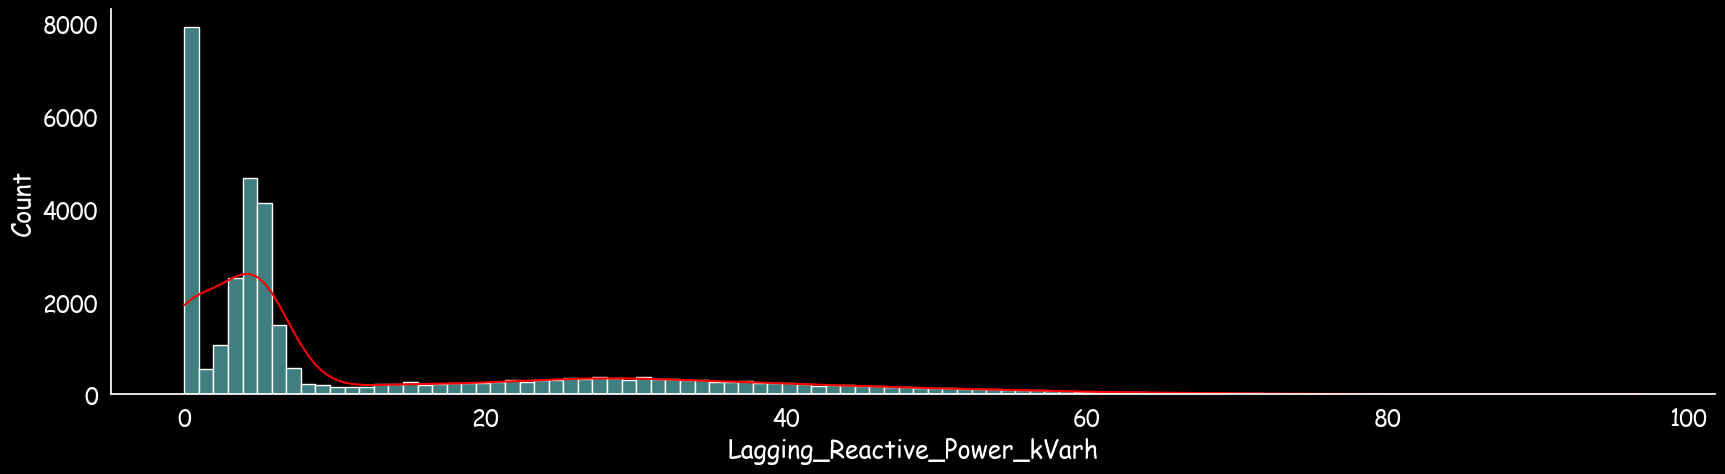

In [13]:
sns.displot(data=df, x="Lagging_Reactive_Power_kVarh", kde=True, bins = 100,color = "red", facecolor = "#3F7F7F",height = 5, aspect = 3.5);

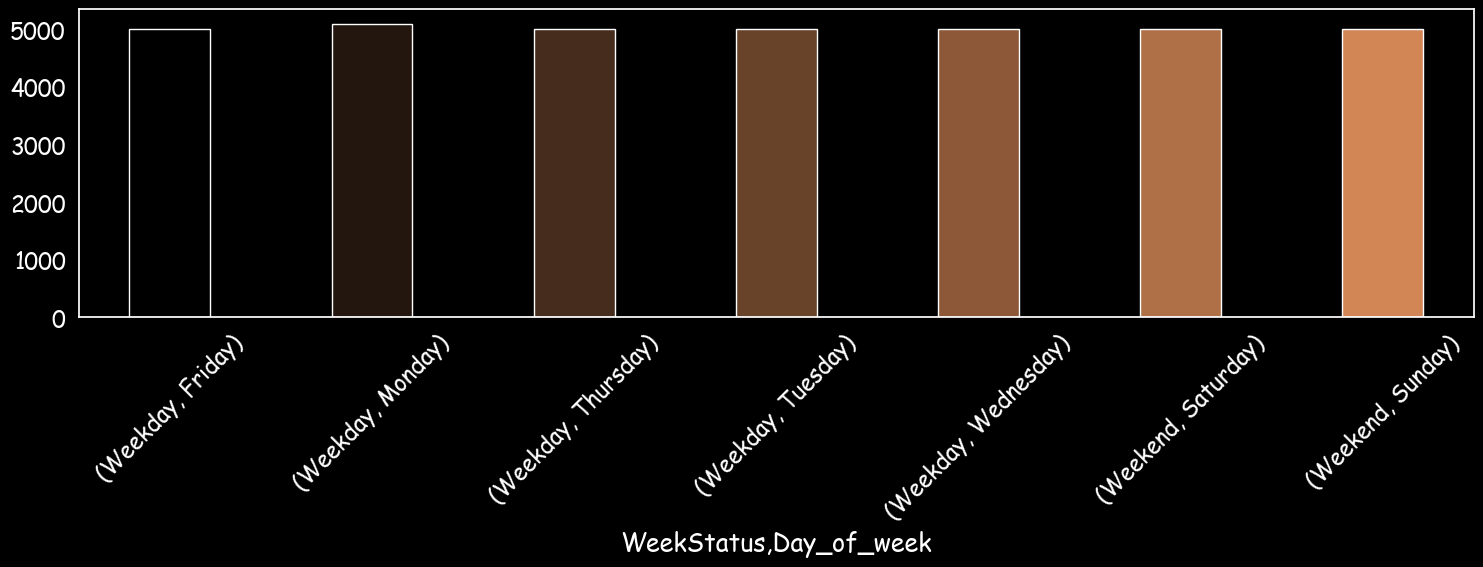

In [14]:
plt.figure(figsize=(18,4))
color = plt.cm.copper(np.linspace(0, 1, 10))
df.groupby(['WeekStatus','Day_of_week'])['Usage_kWh'].count().plot(kind='bar', width=.4,color=color);
plt.xticks(rotation=45);

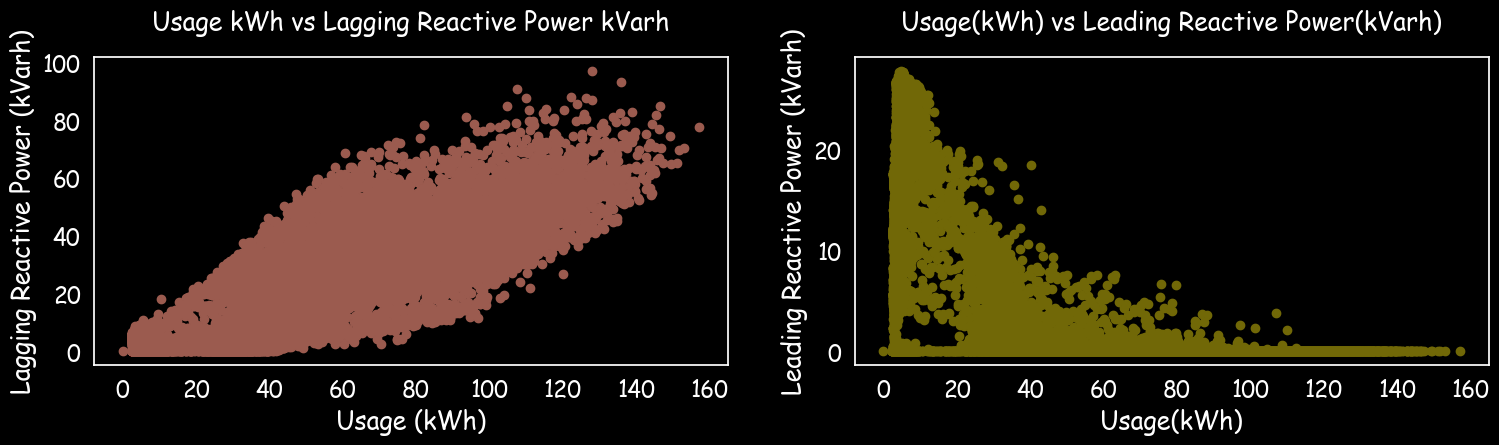

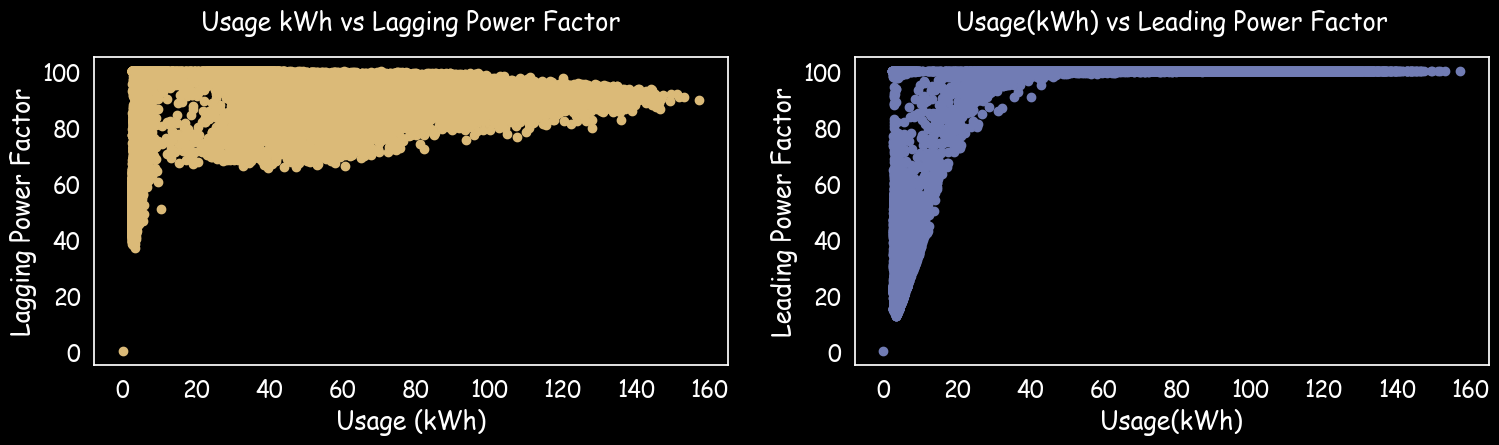

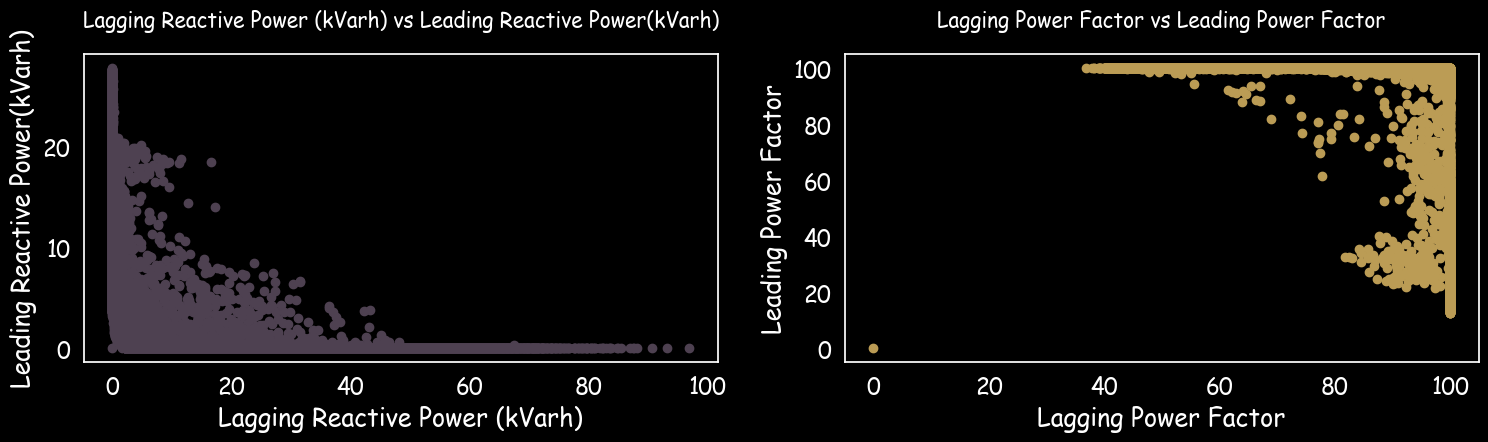

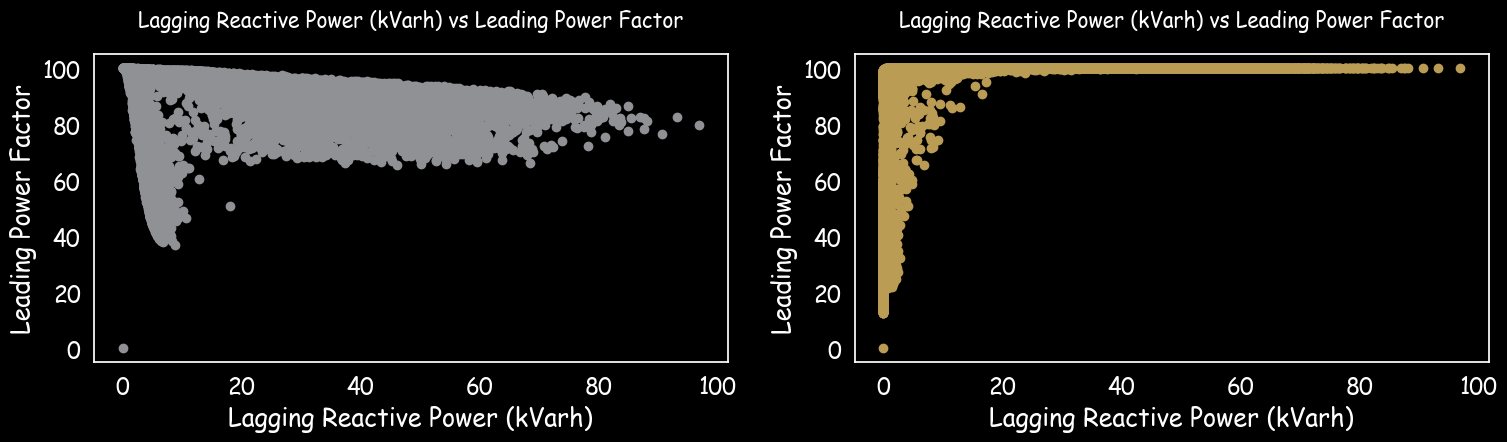

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(18,4))
fig, (ax3,ax4) = plt.subplots(1,2, figsize=(18,4))
fig, (ax5,ax6) = plt.subplots(1,2, figsize=(18,4))
fig, (ax7,ax8) = plt.subplots(1,2, figsize=(18,4))

ax1.scatter(data=df,x="Usage_kWh", y="Lagging_Reactive_Power_kVarh", color=colors[1])
ax1.set_title("Usage kWh vs Lagging Reactive Power kVarh",pad=20)
ax1.set_xlabel("Usage (kWh)")
ax1.set_ylabel("Lagging Reactive Power (kVarh)")

ax2.scatter(data=df,x="Usage_kWh",y="Leading_Reactive_Power_kVarh", color=colors[8])
ax2.set_title("Usage(kWh) vs Leading Reactive Power(kVarh)",pad=20)
ax2.set_xlabel("Usage(kWh)")
ax2.set_ylabel("Leading Reactive Power (kVarh)")

ax3.scatter(data=df,x="Usage_kWh", y="Lagging_Power_Factor", color=colors[3])
ax3.set_title("Usage kWh vs Lagging Power Factor",pad=20)
ax3.set_xlabel("Usage (kWh)")
ax3.set_ylabel("Lagging Power Factor")

ax4.scatter(data=df,x="Usage_kWh",y="Leading_Power_Factor", color=colors[9]) 
ax4.set_title("Usage(kWh) vs Leading Power Factor",pad=20)
ax4.set_xlabel("Usage(kWh)")
ax4.set_ylabel("Leading Power Factor")

ax5.scatter(data=df,x="Lagging_Reactive_Power_kVarh",y="Leading_Reactive_Power_kVarh", color=colors[2]) 
ax5.set_title("Lagging Reactive Power (kVarh) vs Leading Reactive Power(kVarh)",pad=20,fontsize=15)
ax5.set_xlabel("Lagging Reactive Power (kVarh)")
ax5.set_ylabel("Leading Reactive Power(kVarh)")

ax6.scatter(data=df,x="Lagging_Power_Factor",y="Leading_Power_Factor", color=colors[4]) 
ax6.set_title("Lagging Power Factor vs Leading Power Factor",pad=20,fontsize=15)
ax6.set_xlabel("Lagging Power Factor")
ax6.set_ylabel("Leading Power Factor")

ax7.scatter(data=df,x="Lagging_Reactive_Power_kVarh",y="Lagging_Power_Factor", color=colors[5]) 
ax7.set_title("Lagging Reactive Power (kVarh) vs Leading Power Factor",pad=20,fontsize=15)
ax7.set_xlabel("Lagging Reactive Power (kVarh)")
ax7.set_ylabel("Leading Power Factor")

ax8.scatter(data=df,x="Lagging_Reactive_Power_kVarh",y="Leading_Power_Factor", color=colors[4]) 
ax8.set_title("Lagging Reactive Power (kVarh) vs Leading Power Factor",pad=20,fontsize=15)
ax8.set_xlabel("Lagging Reactive Power (kVarh)")
ax8.set_ylabel("Leading Power Factor")

plt.show()

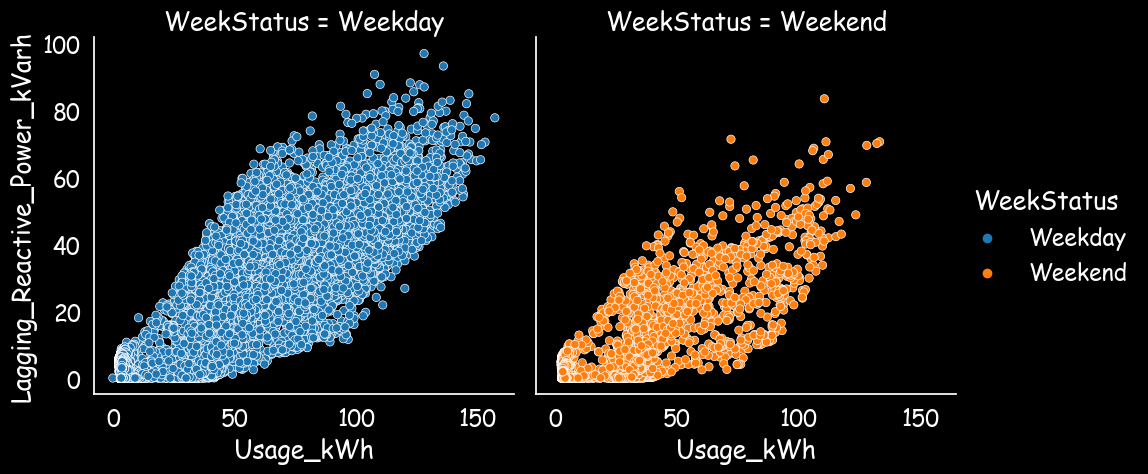

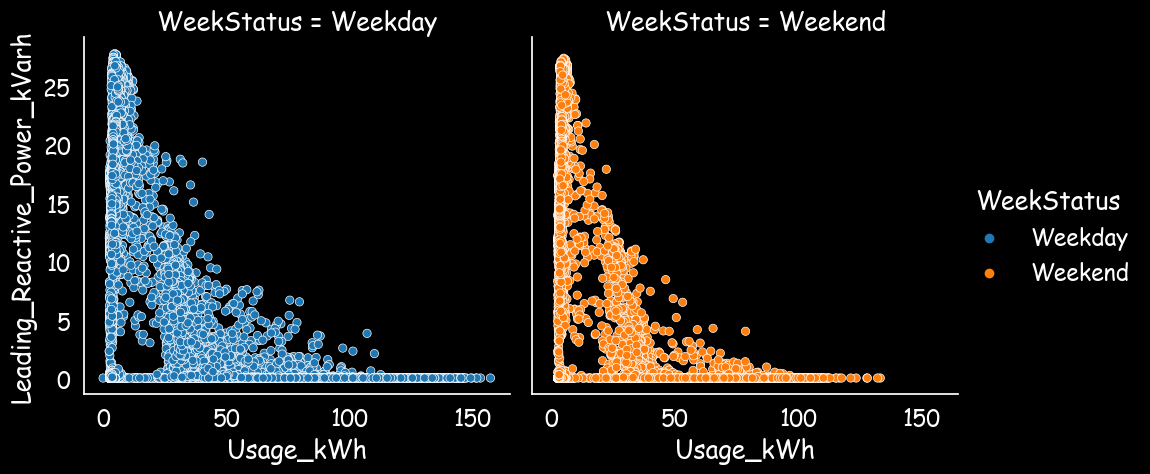

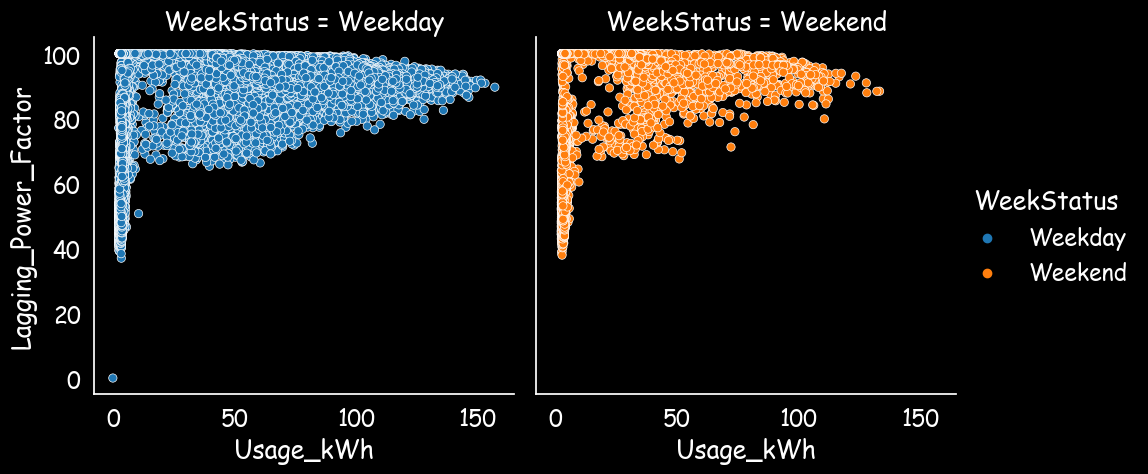

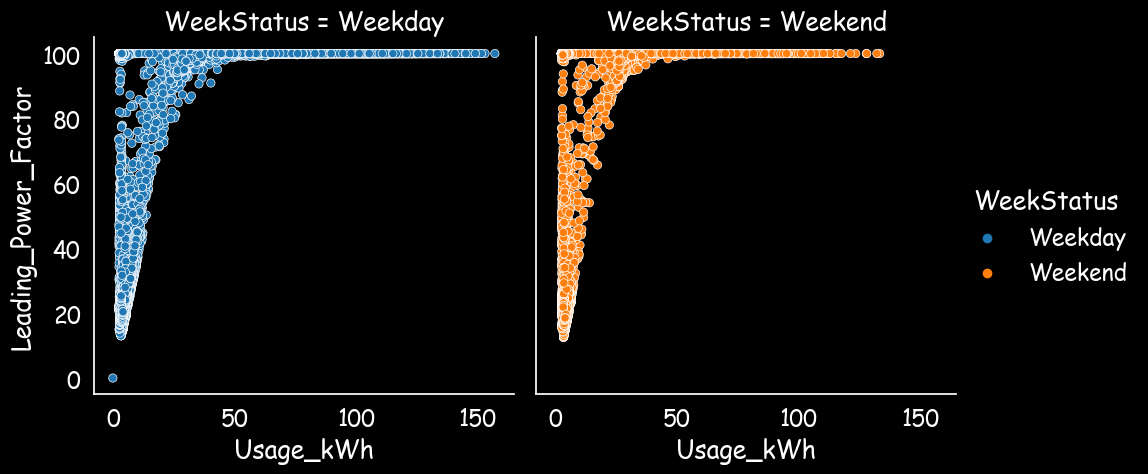

In [16]:
sns.relplot(data=df, x="Usage_kWh", y="Lagging_Reactive_Power_kVarh", hue="WeekStatus",col="WeekStatus",palette='tab10');
sns.relplot(data=df, x="Usage_kWh", y="Leading_Reactive_Power_kVarh", hue="WeekStatus",col="WeekStatus",palette='tab10');
sns.relplot(data=df, x="Usage_kWh", y="Lagging_Power_Factor", hue="WeekStatus",col="WeekStatus",palette='tab10');
sns.relplot(data=df, x="Usage_kWh", y="Leading_Power_Factor", hue="WeekStatus",col="WeekStatus",palette='tab10');

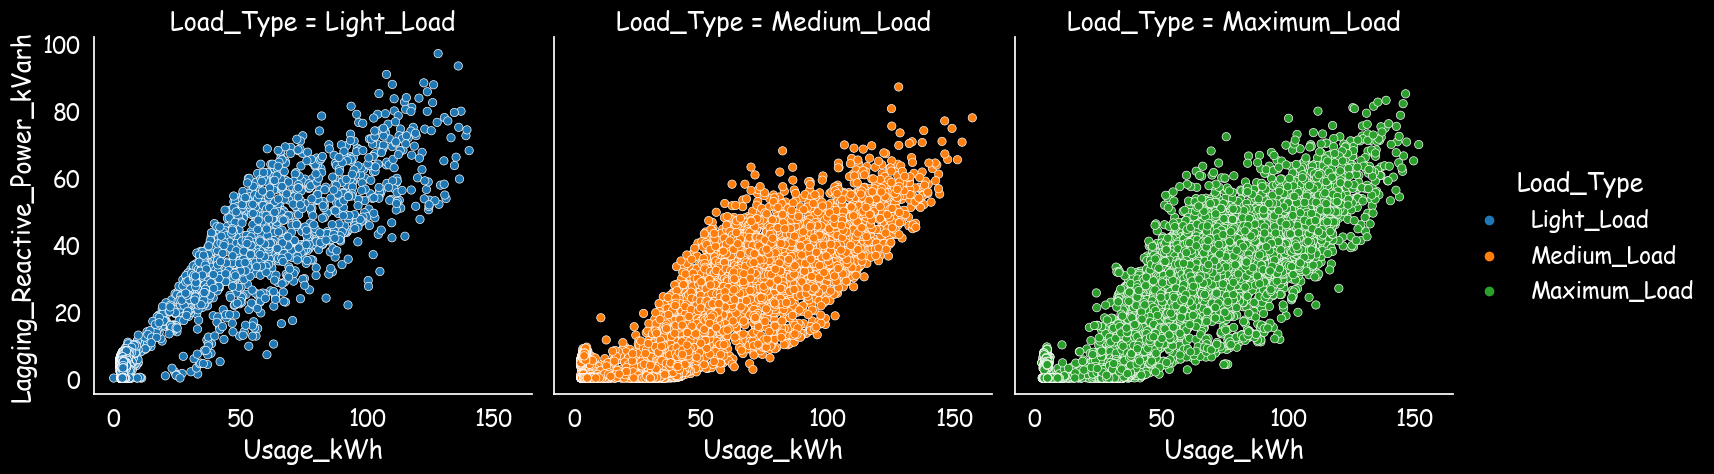

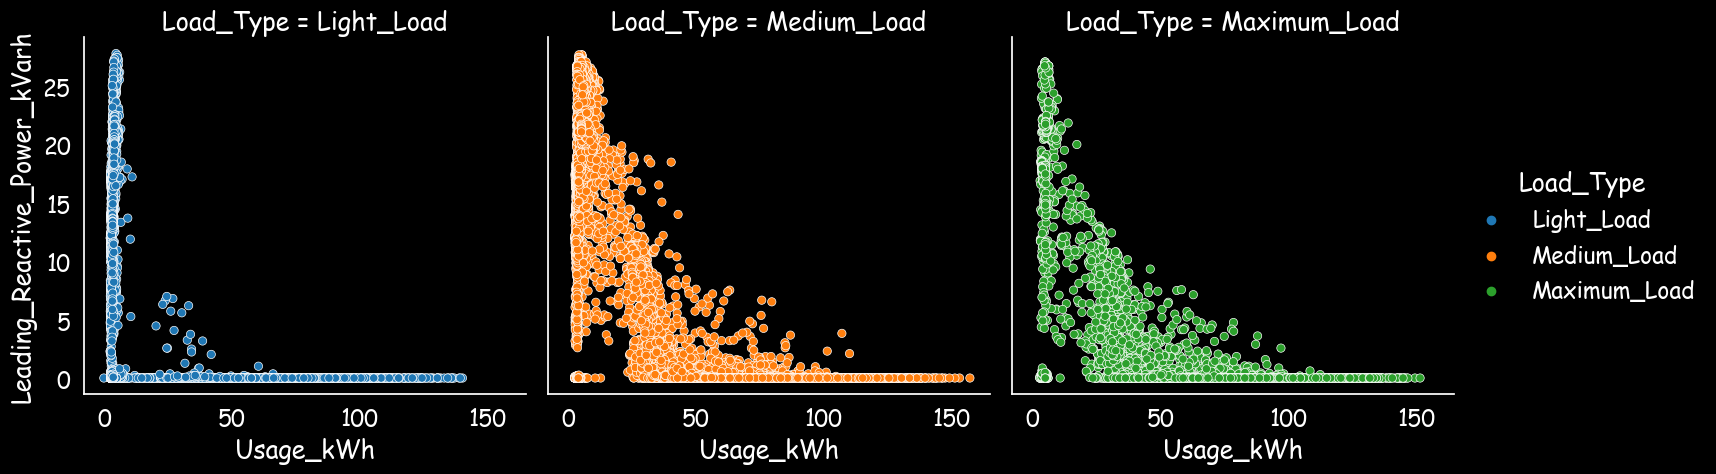

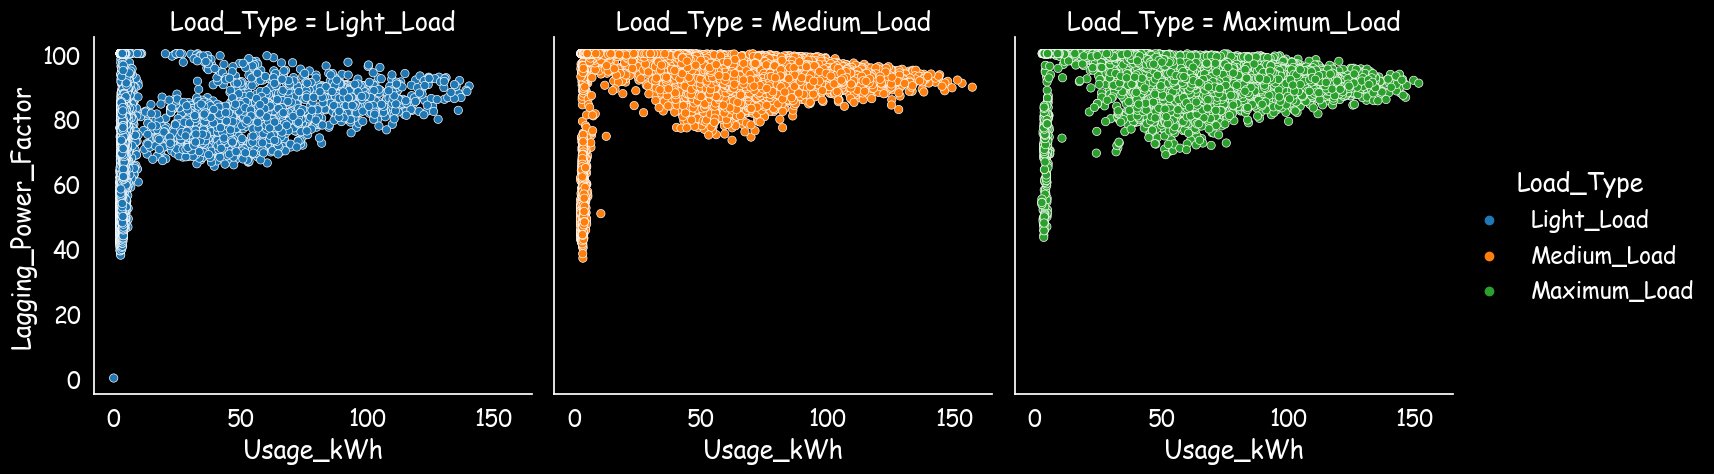

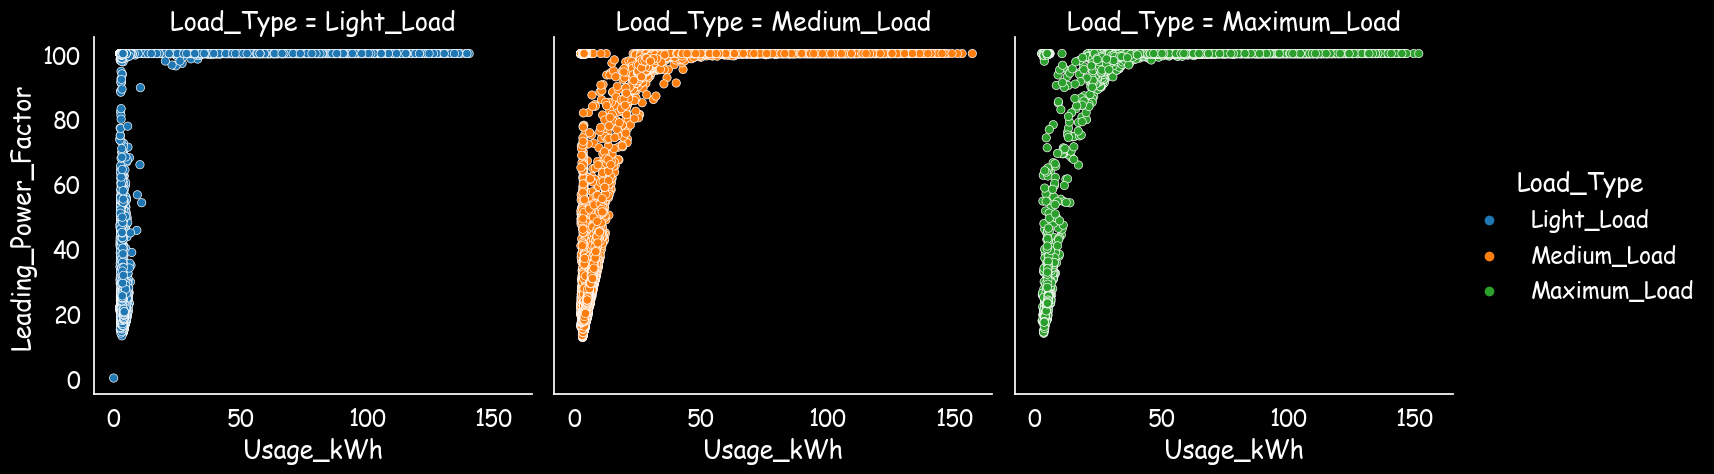

In [17]:
sns.relplot(data=df, x="Usage_kWh", y="Lagging_Reactive_Power_kVarh", hue="Load_Type",col="Load_Type",palette='tab10');
sns.relplot(data=df, x="Usage_kWh", y="Leading_Reactive_Power_kVarh", hue="Load_Type",col="Load_Type",palette='tab10');
sns.relplot(data=df, x="Usage_kWh", y="Lagging_Power_Factor", hue="Load_Type",col="Load_Type",palette='tab10');
sns.relplot(data=df, x="Usage_kWh", y="Leading_Power_Factor", hue="Load_Type",col="Load_Type",palette='tab10');

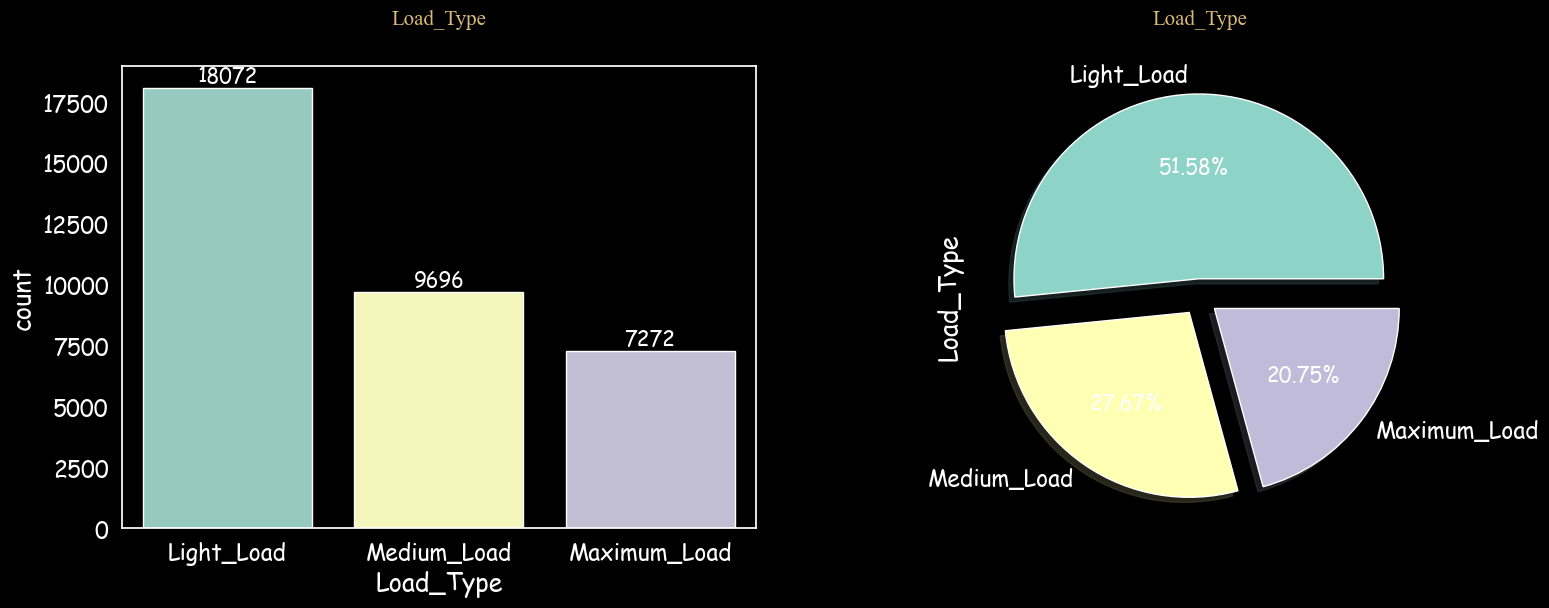

In [18]:
ax = plt.figure(figsize=(18,6))
ax = plt.subplot(1,2,1)
ax = sns.countplot(x='Load_Type', data=df)
ax.bar_label(ax.containers[0])
plt.title("Load_Type", fontsize=20,color='#dbba78',font='Times New Roman',pad=30)
ax =plt.subplot(1,2,2)
ax=df['Load_Type'].value_counts().plot.pie(explode=[0.1, 0.1,0.1],autopct='%1.2f%%',shadow=True);
ax.set_title(label = "Load_Type", fontsize = 20,color='#dbba78',font='Times New Roman',pad=30);

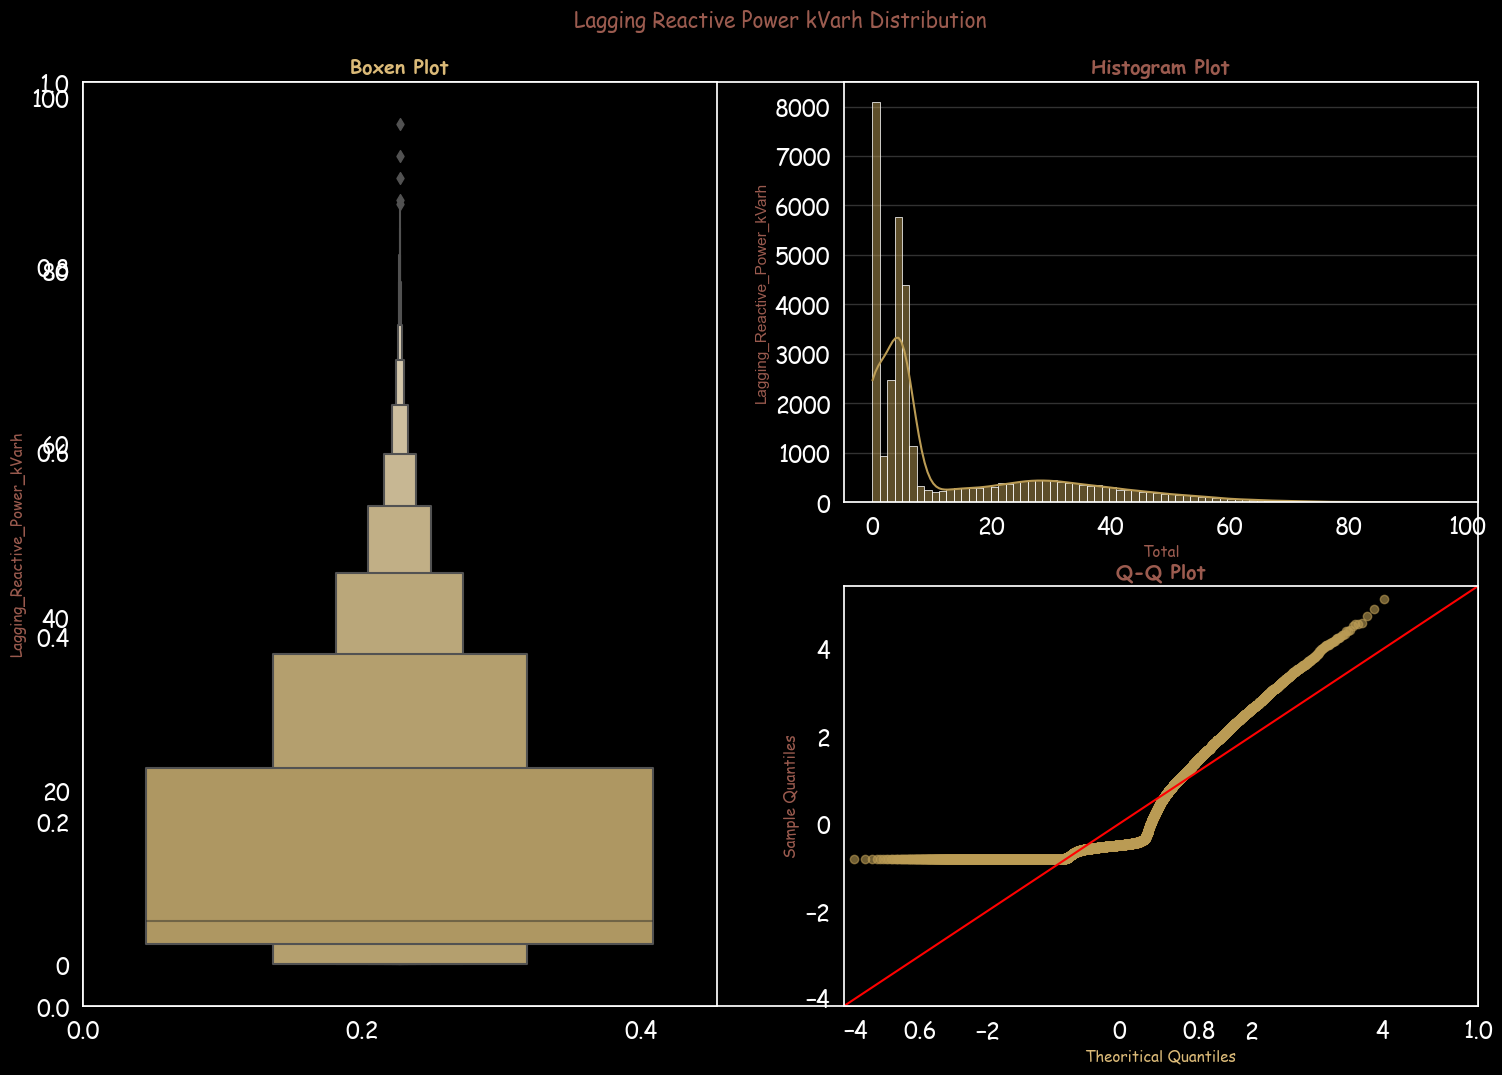

In [19]:
from statsmodels.graphics.gofplots import qqplot

var = df['Lagging_Reactive_Power_kVarh']
color = colors[4]
fig = plt.figure(figsize = (18, 12))

# --- Title ---
plt.title("Lagging Reactive Power kVarh Distribution",fontsize=20,font='Comic Sans MS',pad=40,color = colors[1])

# --- Histogram ---
ax_1=fig.add_subplot(2, 2, 2)
plt.title('Histogram Plot', fontweight = 'bold', fontsize = 14, fontfamily = 'Comic Sans MS', color = colors[1])
sns.histplot(data = df, x = var, kde = True, color = color)
plt.xlabel('Total', fontweight = 'regular', fontsize = 11, fontfamily = 'Comic Sans MS', color = colors[1])
plt.ylabel('Lagging_Reactive_Power_kVarh', fontweight = 'regular', fontsize = 11, fontfamily = 'sans-serif', color = colors[1])
plt.grid(axis = 'x', alpha = 0)
plt.grid(axis = 'y', alpha = 0.2)

# --- Q-Q Plot ---
ax_2 = fig.add_subplot(2, 2, 4)
plt.title('Q-Q Plot', fontweight = 'bold', fontsize = 14, fontfamily = 'Comic Sans MS', color = colors[1])
qqplot(var, fit = True, line = '45', ax = ax_2, markerfacecolor = color, markeredgecolor = color, alpha = 0.6)
plt.xlabel('Theoritical Quantiles', fontweight = 'regular', fontsize = 11, fontfamily = 'Comic Sans MS', 
           color = colors[3])
plt.ylabel('Sample Quantiles', fontweight = 'regular', fontsize = 11, fontfamily = 'Comic Sans MS', color = colors[1])

# --- Boxen Plot ---
ax_3 = fig.add_subplot(1, 2, 1)
plt.title('Boxen Plot', fontweight = 'bold', fontsize = 14, fontfamily = 'Comic Sans MS', color = colors[3])
sns.boxenplot(y = var, data = df, color = color, linewidth = 1.5)
plt.ylabel('Lagging_Reactive_Power_kVarh', fontweight = 'regular', fontsize = 11, fontfamily = 'Comic Sans MS', color = colors[1])

plt.show();

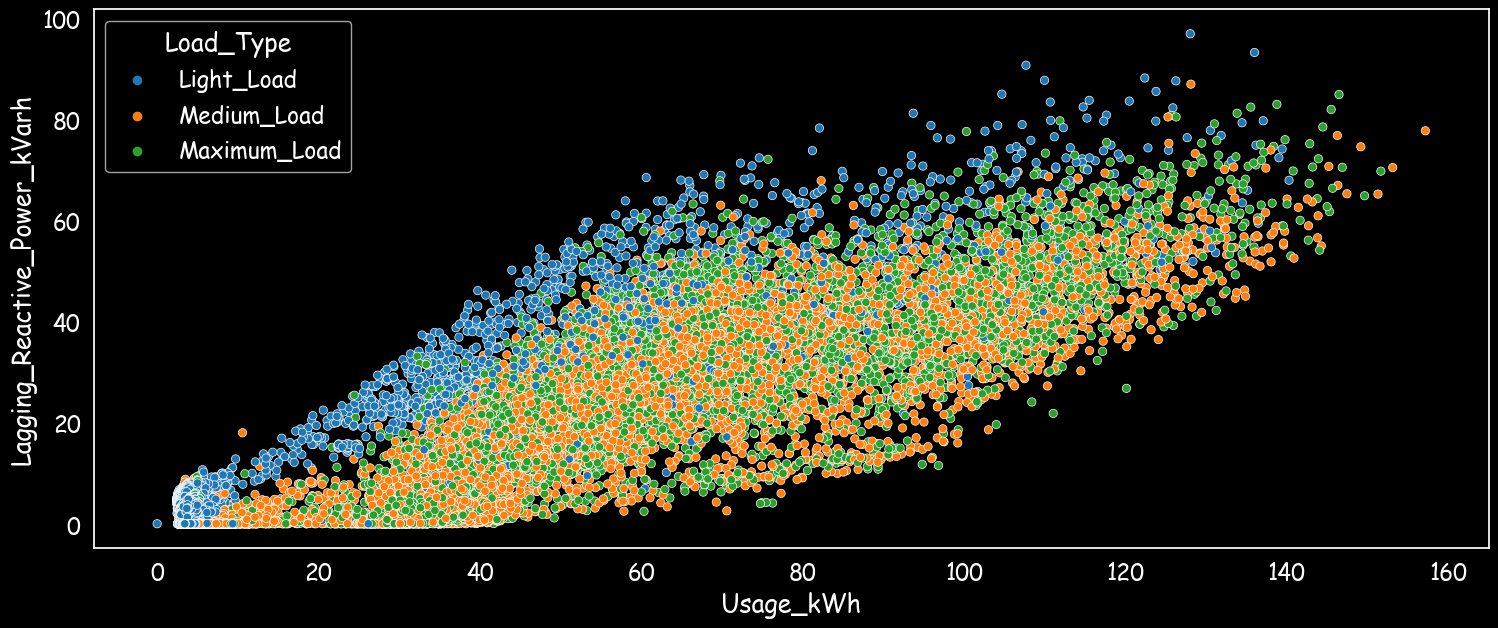

In [20]:
plt.figure(figsize=(18,7))
sns.scatterplot(data=df, x="Usage_kWh", y="Lagging_Reactive_Power_kVarh", hue="Load_Type",palette="tab10");

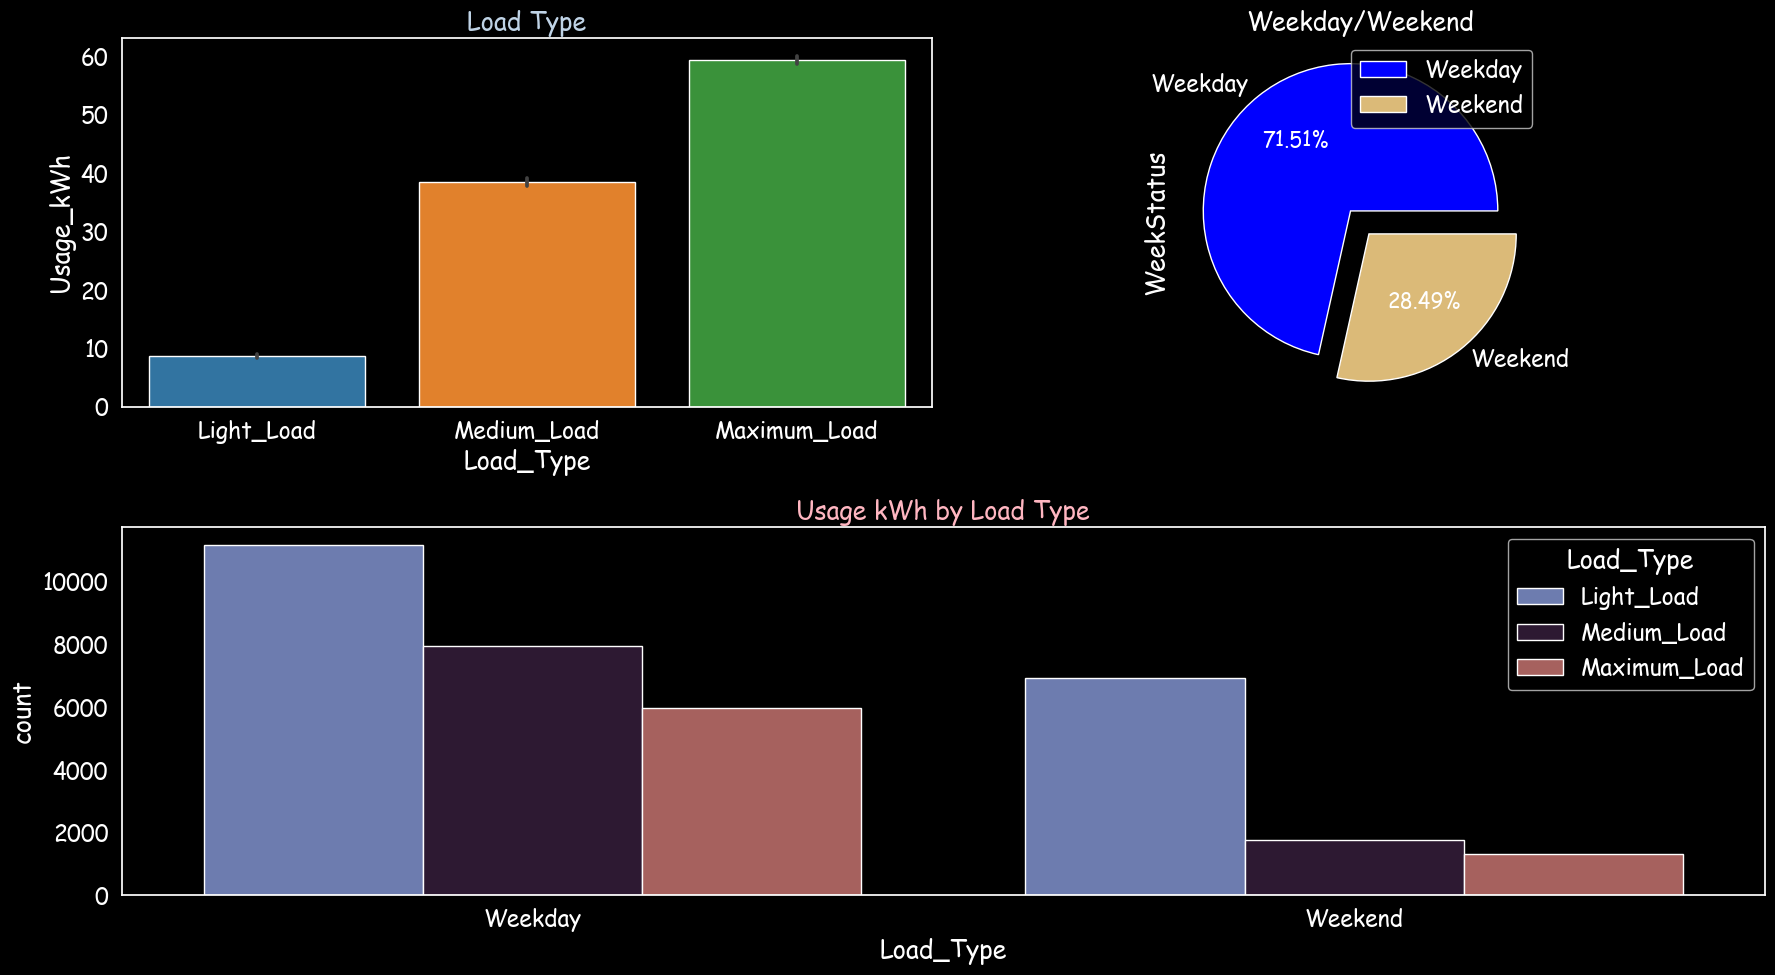

In [21]:
plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
sns.barplot(x = 'Load_Type', y = 'Usage_kWh', palette= "tab10",data=df)
plt.title("Load Type", color = "#bfd3e6")
plt.xlabel("Load_Type")
plt.ylabel("Usage_kWh")

plt.subplot(2,2,2)
df["WeekStatus"].value_counts().plot.pie(autopct='%1.2f%%', explode=[0.1, 0.1], colors=['blue','#dbba78'])
p = plt.gcf()
plt.title("Weekday/Weekend")
plt.legend()
plt.subplot(2,2,(3,4))

sns.countplot(x = 'WeekStatus', hue = 'Load_Type', data = df, palette="twilight")
plt.title("Usage kWh by Load Type", color = "Lightpink")
plt.xlabel("Load_Type")
plt.tight_layout()
plt.show()

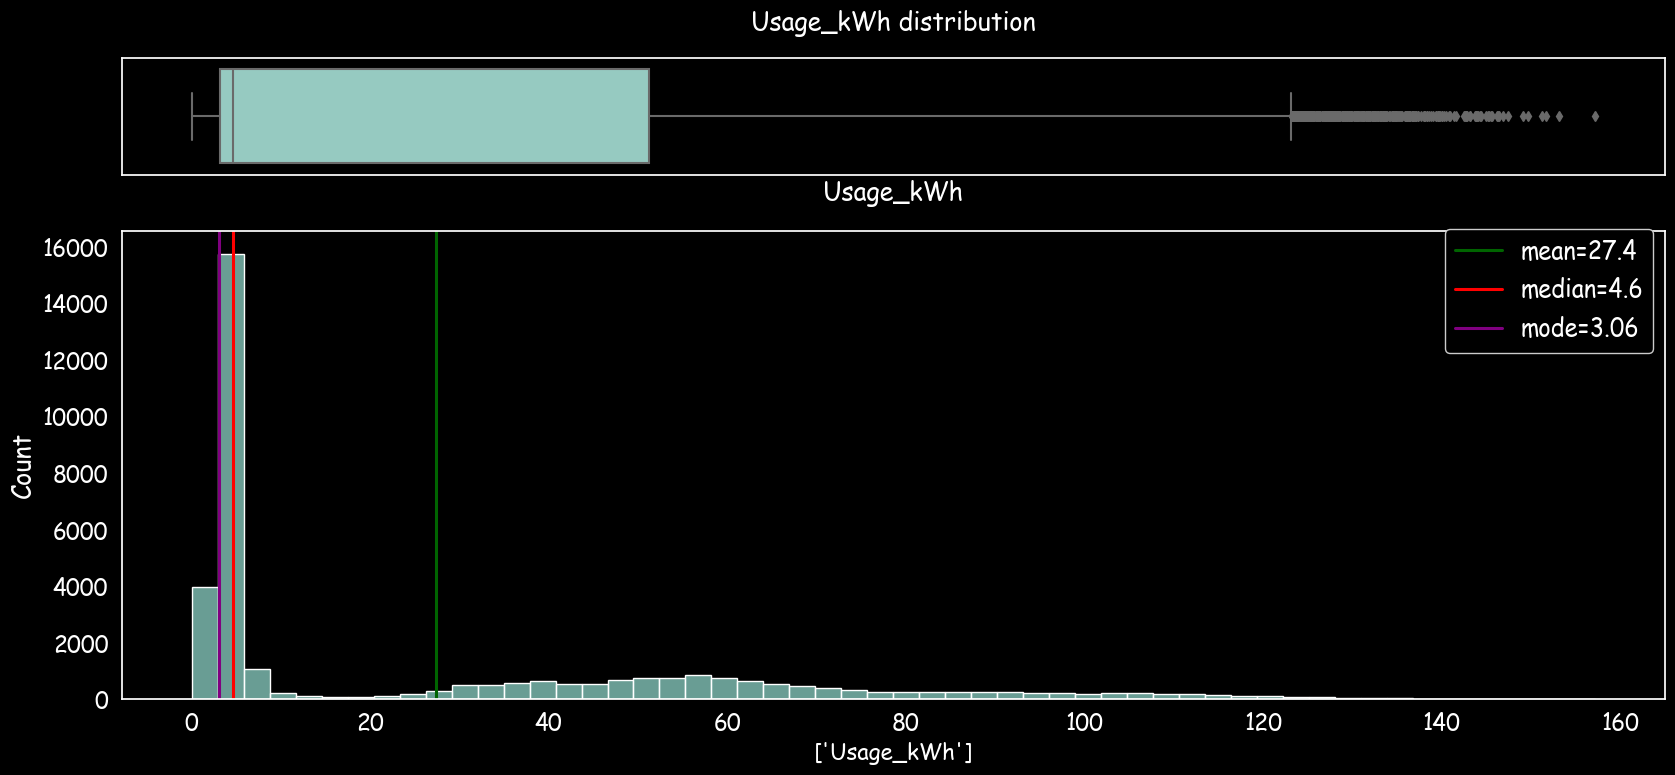

In [22]:
col = ['Usage_kWh']
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(17,8),gridspec_kw={"height_ratios": (.2, .8)})
ax[0].set_title('Usage_kWh distribution',fontsize=18,pad=20)
sns.boxplot(x='Usage_kWh', data=df, ax=ax[0])
ax[0].set(yticks=[])
sns.histplot(x='Usage_kWh', data=df, ax=ax[1])
ax[1].set_xlabel(col, fontsize=16)
plt.axvline(df['Usage_kWh'].mean(), color='darkgreen', linewidth=2.2, label='mean=' + str(np.round(df['Usage_kWh'].mean(),1)))
plt.axvline(df['Usage_kWh'].median(), color='red', linewidth=2.2, label='median='+ str(np.round(df['Usage_kWh'].median(),1)))
plt.axvline(df['Usage_kWh'].mode()[0], color='purple', linewidth=2.2, label='mode='+ str(df['Usage_kWh'].mode()[0]))
plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fontsize=17, fancybox=True, shadow=True, frameon=True)
plt.tight_layout()
plt.show()

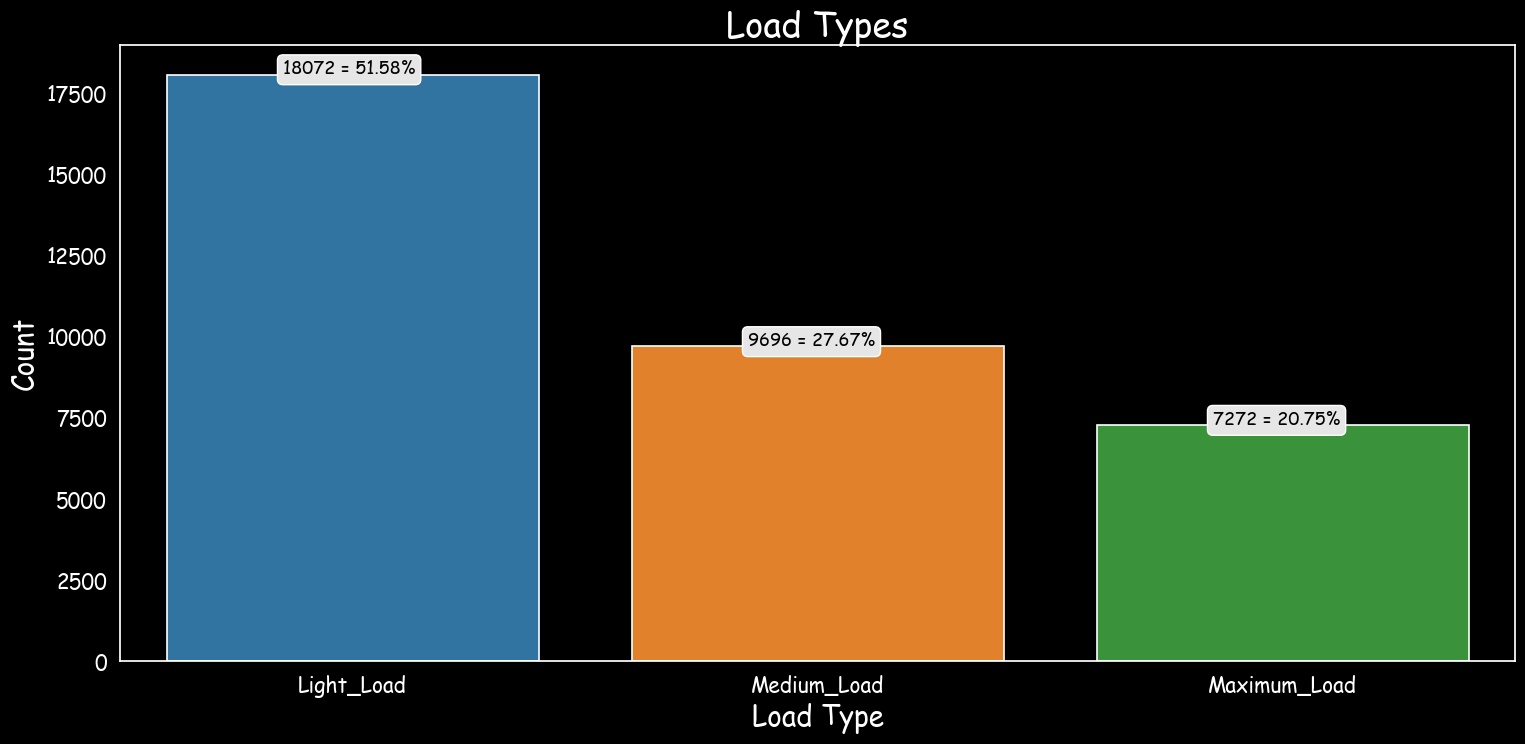

In [23]:
#Disaster count(Whether the disaster happened or not )
plt.figure(figsize = (18, 8))
ax = plt.axes()
ax.set_facecolor('black')
ax = sns.countplot(x = 'Load_Type', data = df, palette = 'tab10', edgecolor = 'white', linewidth = 1.2)
plt.title('Load Types', fontsize = 25)
plt.xlabel('Load Type', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
ax.xaxis.set_tick_params(labelsize = 15)
ax.yaxis.set_tick_params(labelsize = 15)
bbox_args = dict(boxstyle = 'round', fc = '0.9')
for p in ax.patches:
        ax.annotate('{:.0f} = {:.2f}%'.format(p.get_height(), (p.get_height() / len(df['Load_Type'])) * 100), (p.get_x() + 0.25, p.get_height() + 10), 
                   color = 'black',
                   bbox = bbox_args,
                   fontsize = 13)
plt.show()

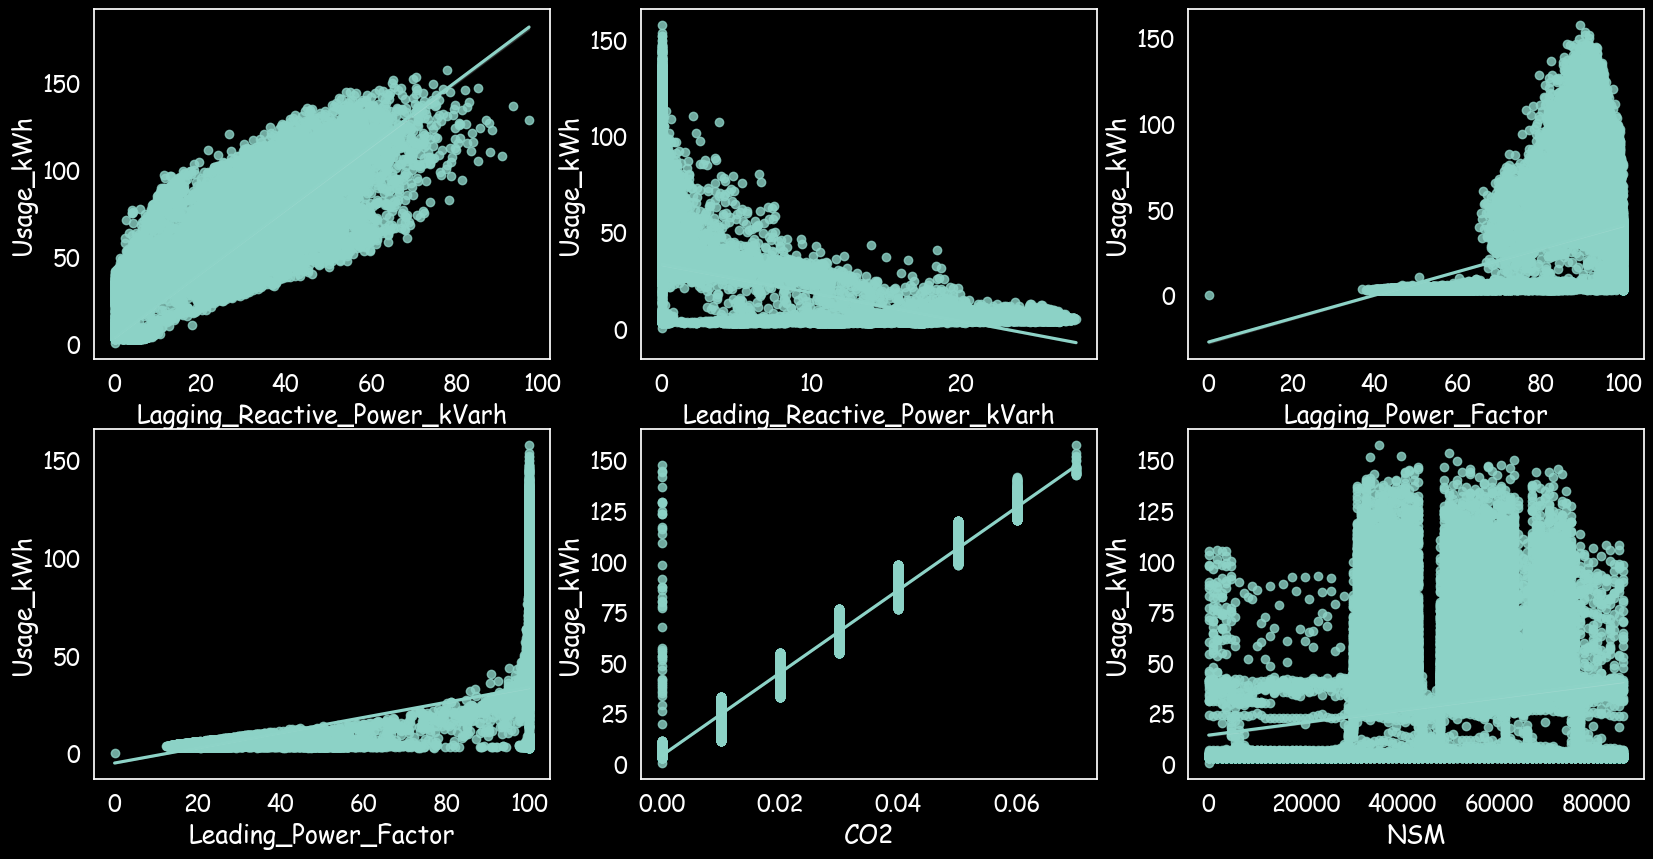

In [24]:
col_names = ['Lagging_Reactive_Power_kVarh','Leading_Reactive_Power_kVarh','Lagging_Power_Factor','Leading_Power_Factor','CO2',"NSM"]
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(20,10))
for i in range(0, len(col_names)):
    rows = i // 3 
    cols = i % 3
    ax = axs[rows,cols]
    plot = sns.regplot(x = col_names[i], y = 'Usage_kWh', data = df, ax = ax )


Skewness: Usage_kWh = 1.197
Kurtosis: Usage_kWh = 0.39
Mean: Usage_kWh = 27.39
Max: Usage_kWh = 157.18
Min: Usage_kWh = 0.0
Median: Usage_kWh = 4.57
Std: Usage_kWh = 33.44
Var: Usage_kWh = 1118.53
Mode: Usage_kWh = 0    3.06
Name: Usage_kWh, dtype: float64


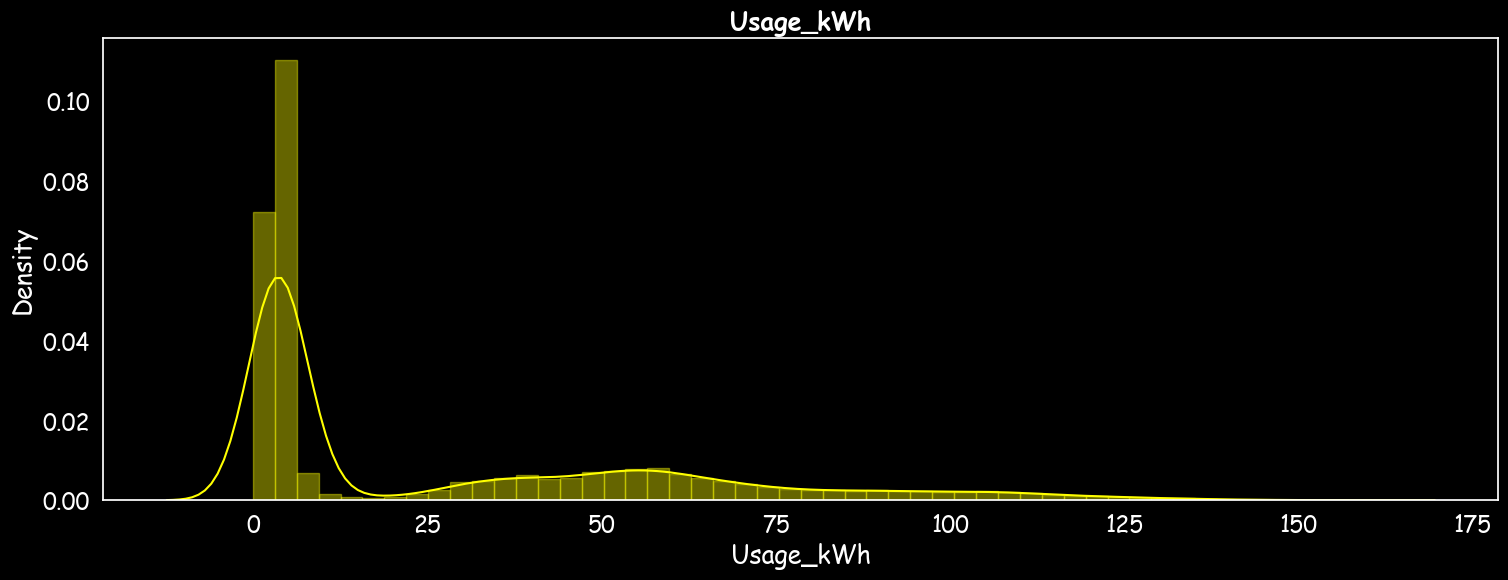



Skewness: Lagging_Reactive_Power_kVarh = 1.438
Kurtosis: Lagging_Reactive_Power_kVarh = 1.21
Mean: Lagging_Reactive_Power_kVarh = 13.04
Max: Lagging_Reactive_Power_kVarh = 96.91
Min: Lagging_Reactive_Power_kVarh = 0.0
Median: Lagging_Reactive_Power_kVarh = 5.0
Std: Lagging_Reactive_Power_kVarh = 16.31
Var: Lagging_Reactive_Power_kVarh = 265.89
Mode: Lagging_Reactive_Power_kVarh = 0    0.0
Name: Lagging_Reactive_Power_kVarh, dtype: float64


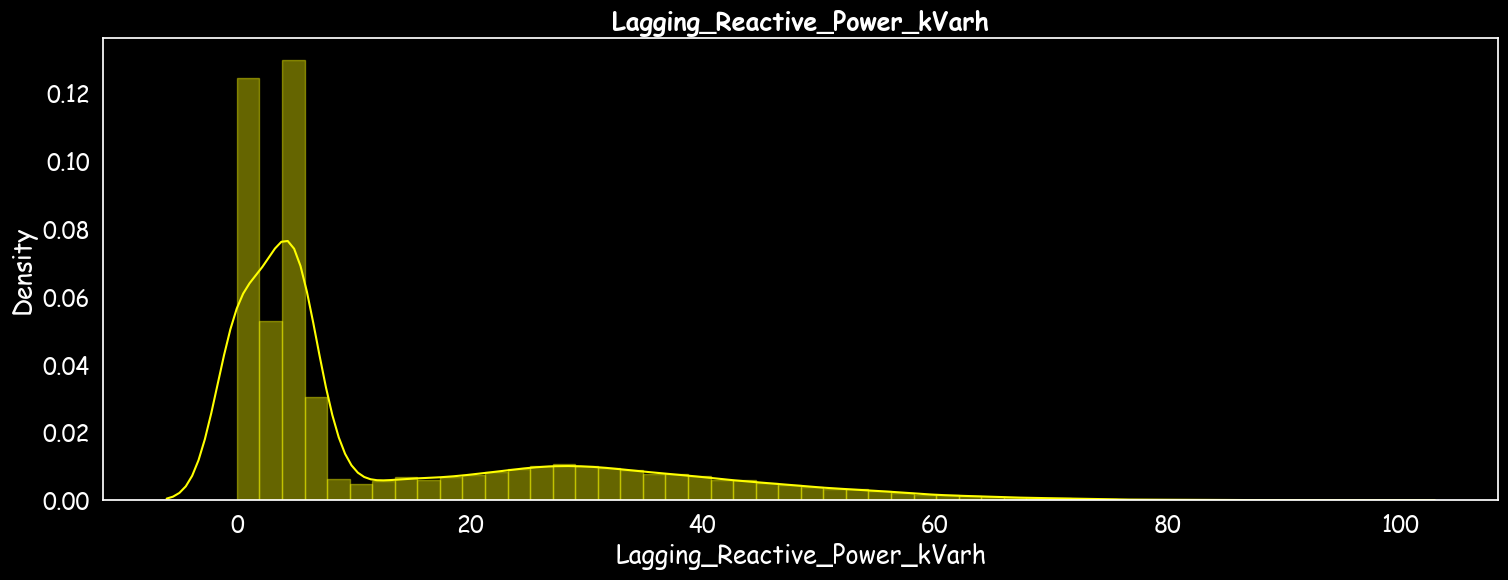



Skewness: Leading_Reactive_Power_kVarh = 1.734
Kurtosis: Leading_Reactive_Power_kVarh = 1.58
Mean: Leading_Reactive_Power_kVarh = 3.87
Max: Leading_Reactive_Power_kVarh = 27.76
Min: Leading_Reactive_Power_kVarh = 0.0
Median: Leading_Reactive_Power_kVarh = 0.0
Std: Leading_Reactive_Power_kVarh = 7.42
Var: Leading_Reactive_Power_kVarh = 55.12
Mode: Leading_Reactive_Power_kVarh = 0    0.0
Name: Leading_Reactive_Power_kVarh, dtype: float64


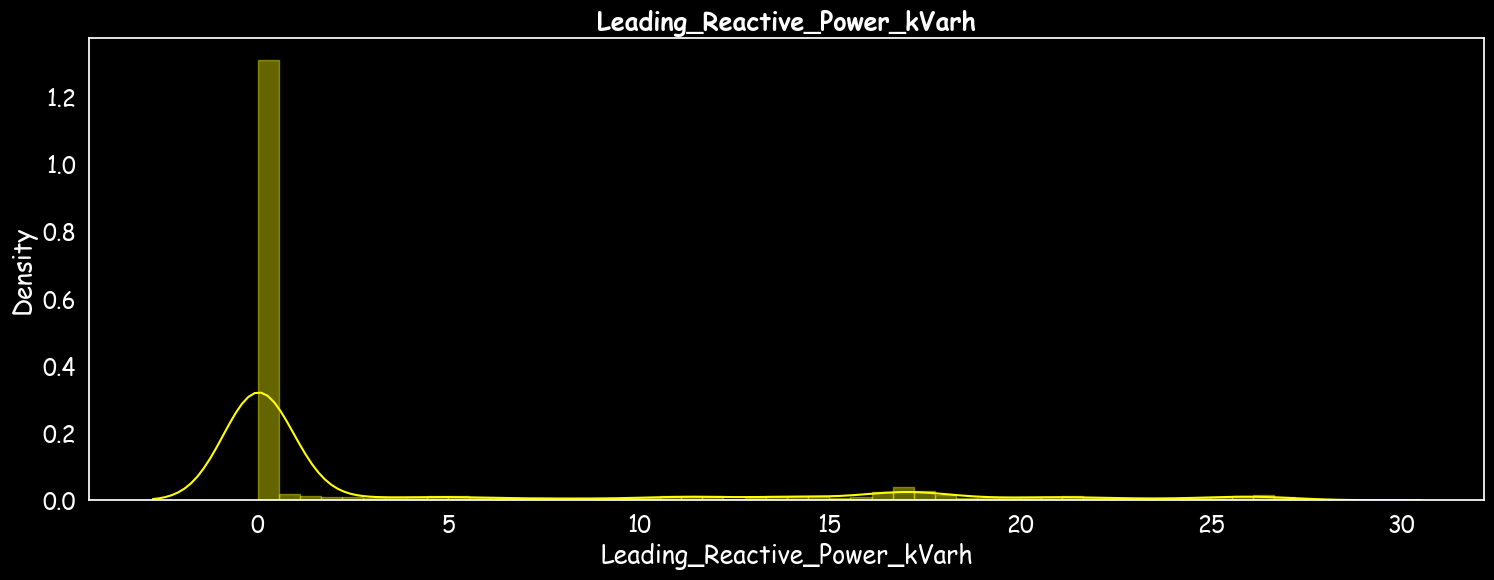



Skewness: Lagging_Power_Factor = -0.606
Kurtosis: Lagging_Power_Factor = -1.1
Mean: Lagging_Power_Factor = 80.58
Max: Lagging_Power_Factor = 100.0
Min: Lagging_Power_Factor = 0.0
Median: Lagging_Power_Factor = 87.96
Std: Lagging_Power_Factor = 18.92
Var: Lagging_Power_Factor = 358.02
Mode: Lagging_Power_Factor = 0    100.0
Name: Lagging_Power_Factor, dtype: float64


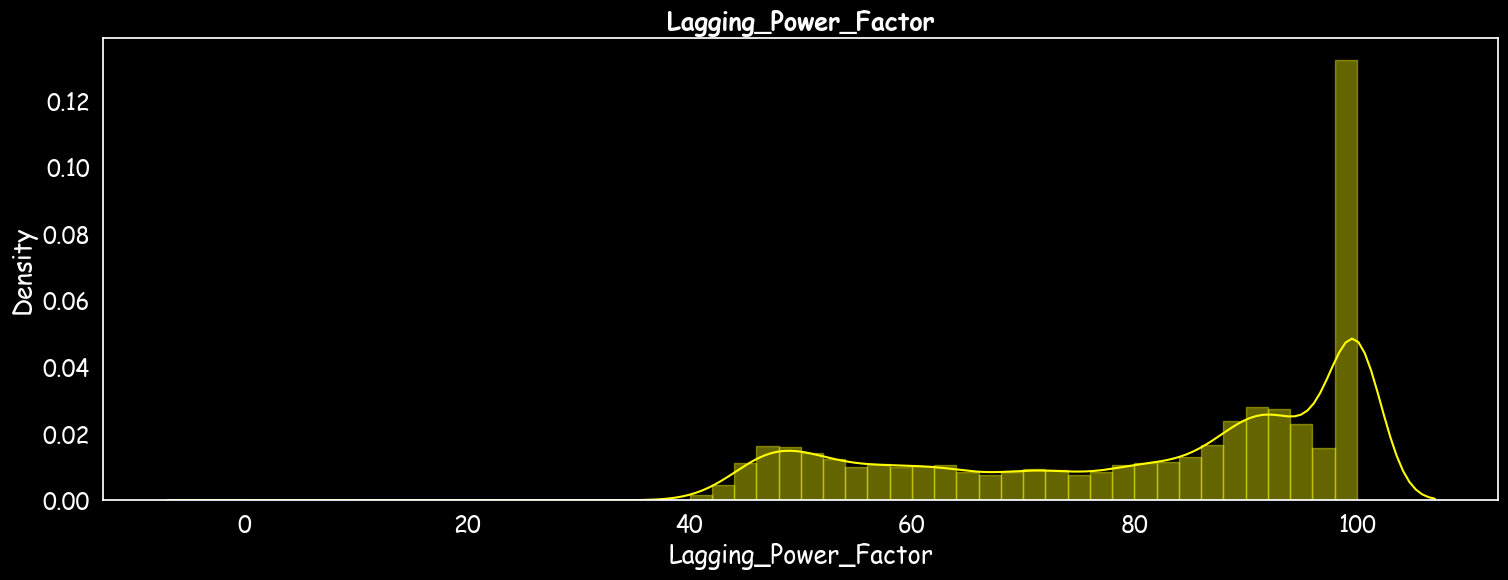



Skewness: Leading_Power_Factor = -1.512
Kurtosis: Leading_Power_Factor = 0.38
Mean: Leading_Power_Factor = 84.37
Max: Leading_Power_Factor = 100.0
Min: Leading_Power_Factor = 0.0
Median: Leading_Power_Factor = 100.0
Std: Leading_Power_Factor = 30.46
Var: Leading_Power_Factor = 927.6
Mode: Leading_Power_Factor = 0    100.0
Name: Leading_Power_Factor, dtype: float64


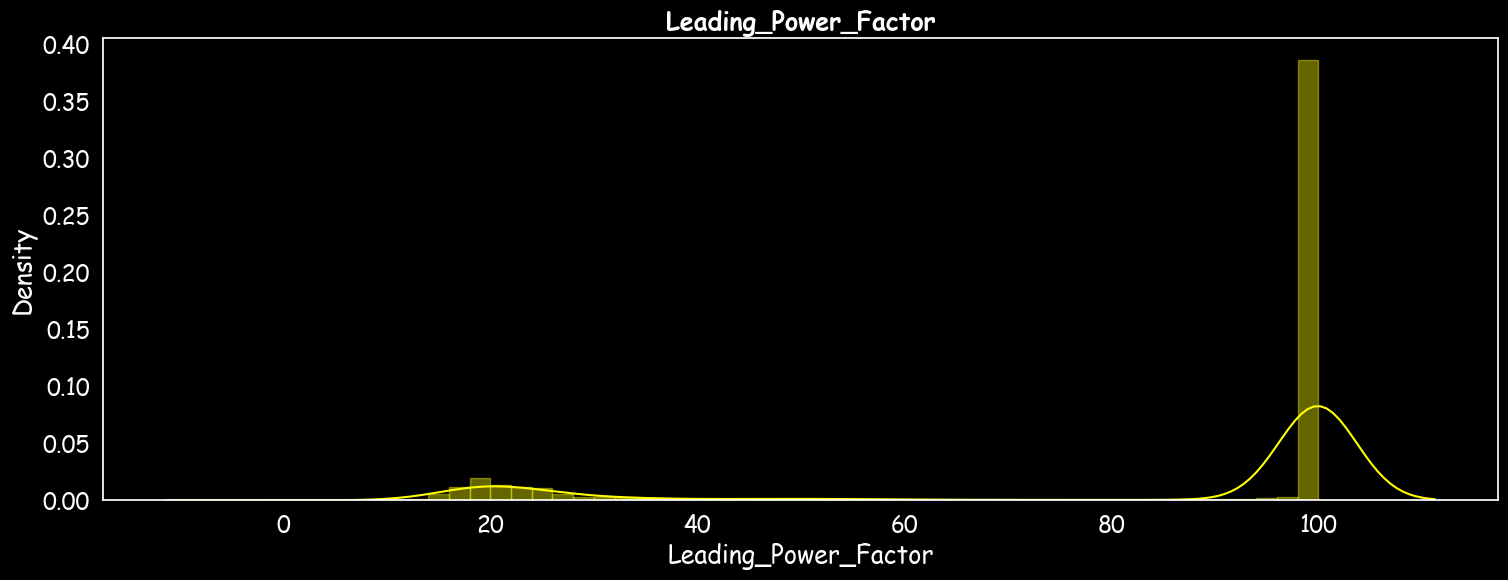

In [25]:
var = ['Usage_kWh', 'Lagging_Reactive_Power_kVarh','Leading_Reactive_Power_kVarh','Lagging_Power_Factor','Leading_Power_Factor']

from scipy.stats import skew

for col in df[var]:
    print(f"\033[91m\033[1m")
    print("Skewness:",col,"=",round(skew(df[col]),3))
    print("Kurtosis:",col,    "=",round(df[col].kurt(),2))
    print("Mean:",col,    "=",round(df[col].mean(),2))
    print("Max:",col,     "=",round(df[col].max(),2))
    print("Min:",col,     "=",round(df[col].min(),2))
    print("Median:",col,  "=",round(df[col].median(),2))
    print("Std:",col,     "=",round(df[col].std(),2))
    print("Var:",col,     "=",round(df[col].var(),2))
    print("Mode:",col,    "=",round(df[col].mode(),2))
    plt.figure(figsize=(18,6))
    sns.distplot(df[col],kde=True,bins=50,color="Yellow",hist_kws={"edgecolor": (1,1,0,1)})
    plt.title(col,fontweight="bold")
    plt.show()
    print(f"\033[93m\033[1m")
    print("====="*25)

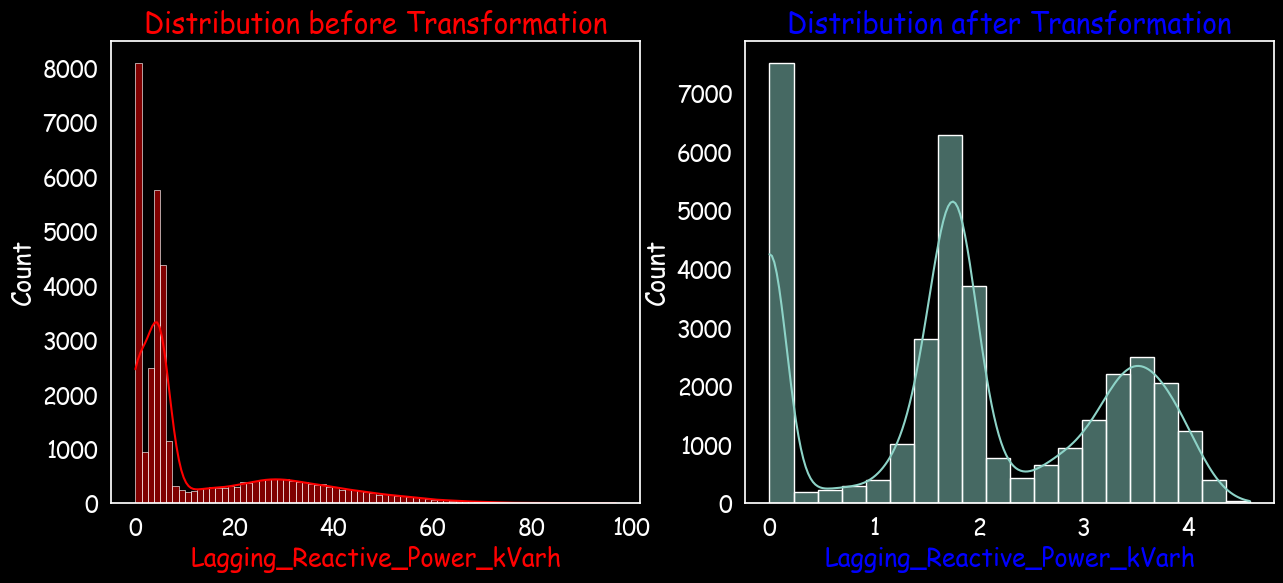

Skewness was 1.44 before & is -0.02 after Log transformation.


In [26]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

old_skew = df.skew().sort_values(ascending=False)
old_skew

def logTrans(feature):   # function to apply transformer and check the distribution with histogram and kdeplot
    
    logTr = ColumnTransformer(transformers=[("lg", FunctionTransformer(np.log1p), [feature])])

    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.title("Distribution before Transformation", fontsize=20,color='red')
    sns.histplot(df[feature], kde=True, color="red")
    plt.xlabel(feature,color='Red')
    
    plt.subplot(1,2,2)
    df_log = pd.DataFrame(logTr.fit_transform(df))
    plt.title("Distribution after Transformation", fontsize=20,color='Blue')
    sns.histplot(df_log,bins=20, kde=True , legend=False)
    plt.xlabel(feature,color='Blue')
    plt.show()
    
    print(f"Skewness was {round(old_skew[feature],2)} before & is {round(df_log.skew()[0],2)} after Log transformation.")
    
logTrans(feature="Lagging_Reactive_Power_kVarh")

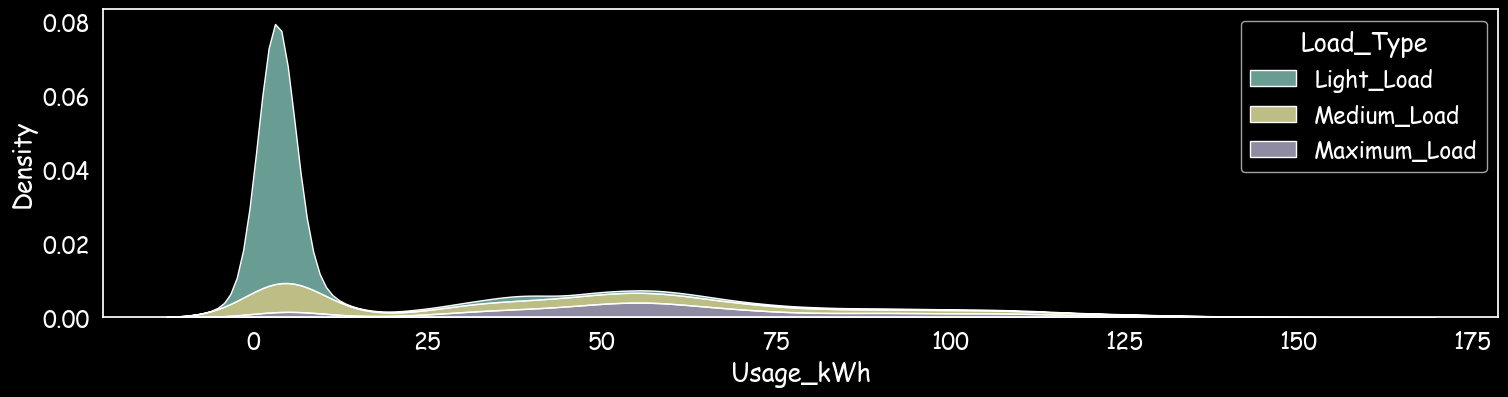

In [27]:
plt.figure(figsize=(18,4))
sns.kdeplot(data=df,x="Usage_kWh",hue='Load_Type',multiple="stack");

In [28]:
# Encode Categorical Columns
from sklearn.preprocessing import LabelEncoder
categ = df.select_dtypes(include = "object").columns

le = LabelEncoder()
df[categ] = df[categ].apply(le.fit_transform)

df.head()

date  Usage_kWh  Lagging_Reactive_Power_kVarh  \
0     1       3.17                          2.95   
1     2       4.00                          4.46   
2     3       3.24                          3.28   
3     4       3.31                          3.56   
4     5       3.82                          4.50   

   Leading_Reactive_Power_kVarh  CO2  Lagging_Power_Factor  \
0                           0.0  0.0                 73.21   
1                           0.0  0.0                 66.77   
2                           0.0  0.0                 70.28   
3                           0.0  0.0                 68.09   
4                           0.0  0.0                 64.72   

   Leading_Power_Factor   NSM  WeekStatus  Day_of_week  Load_Type  
0                 100.0   900           0            1          0  
1                 100.0  1800           0            1          0  
2                 100.0  2700           0            1          0  
3                 100.0  3600           0            1          0  
4                 100.0  4500           0            1          0

In [29]:
# Split the dataset and prepare some lists to store the models
from sklearn.model_selection import train_test_split
X = df.drop(['Load_Type'], axis=1)
y = df.Load_Type

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42) 

In [30]:
models = []

names = [
    "LGBMClassifier",
    "RidgeClassifierCV",
    "XGBClassifier",
    "QuadraticDiscriminantAnalysis",
    "CalibratedClassifierCV",
    "BernoulliNB",
    "BaggingClassifier",
    "LogisticRegression",
    "NearestCentroid",
    "SVC",
    "LinearSVC",
    "KNeighborsClassifier",
    "GaussianNB",
    "Perceptron",
    "SGDClassifier",
    "DecisionTreeClassifier",
    "RandomForestClassifier",
    "MLPClassifier",
    "ExtraTreesClassifier",
    "AdaBoostClassifier",
    "NuSVC"    
]

In [31]:
scores = []

clf =[
    LGBMClassifier(),
    RidgeClassifierCV(),
    XGBClassifier(),
    QuadraticDiscriminantAnalysis(),
    CalibratedClassifierCV(),
    BernoulliNB(),
    BaggingClassifier(),
    LogisticRegression(),
    NearestCentroid(),
    SVC(),
    LinearSVC(),
    KNeighborsClassifier(),
    GaussianNB(),
    Perceptron(),
    SGDClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(),
    ExtraTreesClassifier(),
    AdaBoostClassifier(),
    NuSVC()
      
]

In [32]:
%%time
for model in clf:
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    scores.append(score)
 
final_scores = pd.DataFrame(zip(names,scores), columns=['Classifier', 'Accuracy'])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1628
[LightGBM] [Info] Number of data points in the train set: 26280, number of used features: 10
[LightGBM] [Info] Start training from score -0.660505
[LightGBM] [Info] Start training from score -1.580929
[LightGBM] [Info] Start training from score -1.281482
CPU times: total: 2min 50s
Wall time: 2min 20s


In [33]:
final_scores.sort_values(by='Accuracy',ascending=False).style.background_gradient(cmap="copper").set_properties(**{
            'font-family': 'Comic Sans MS',
            'color': 'Brown',
            'font-size': '15px',"color": "Brown"
        })

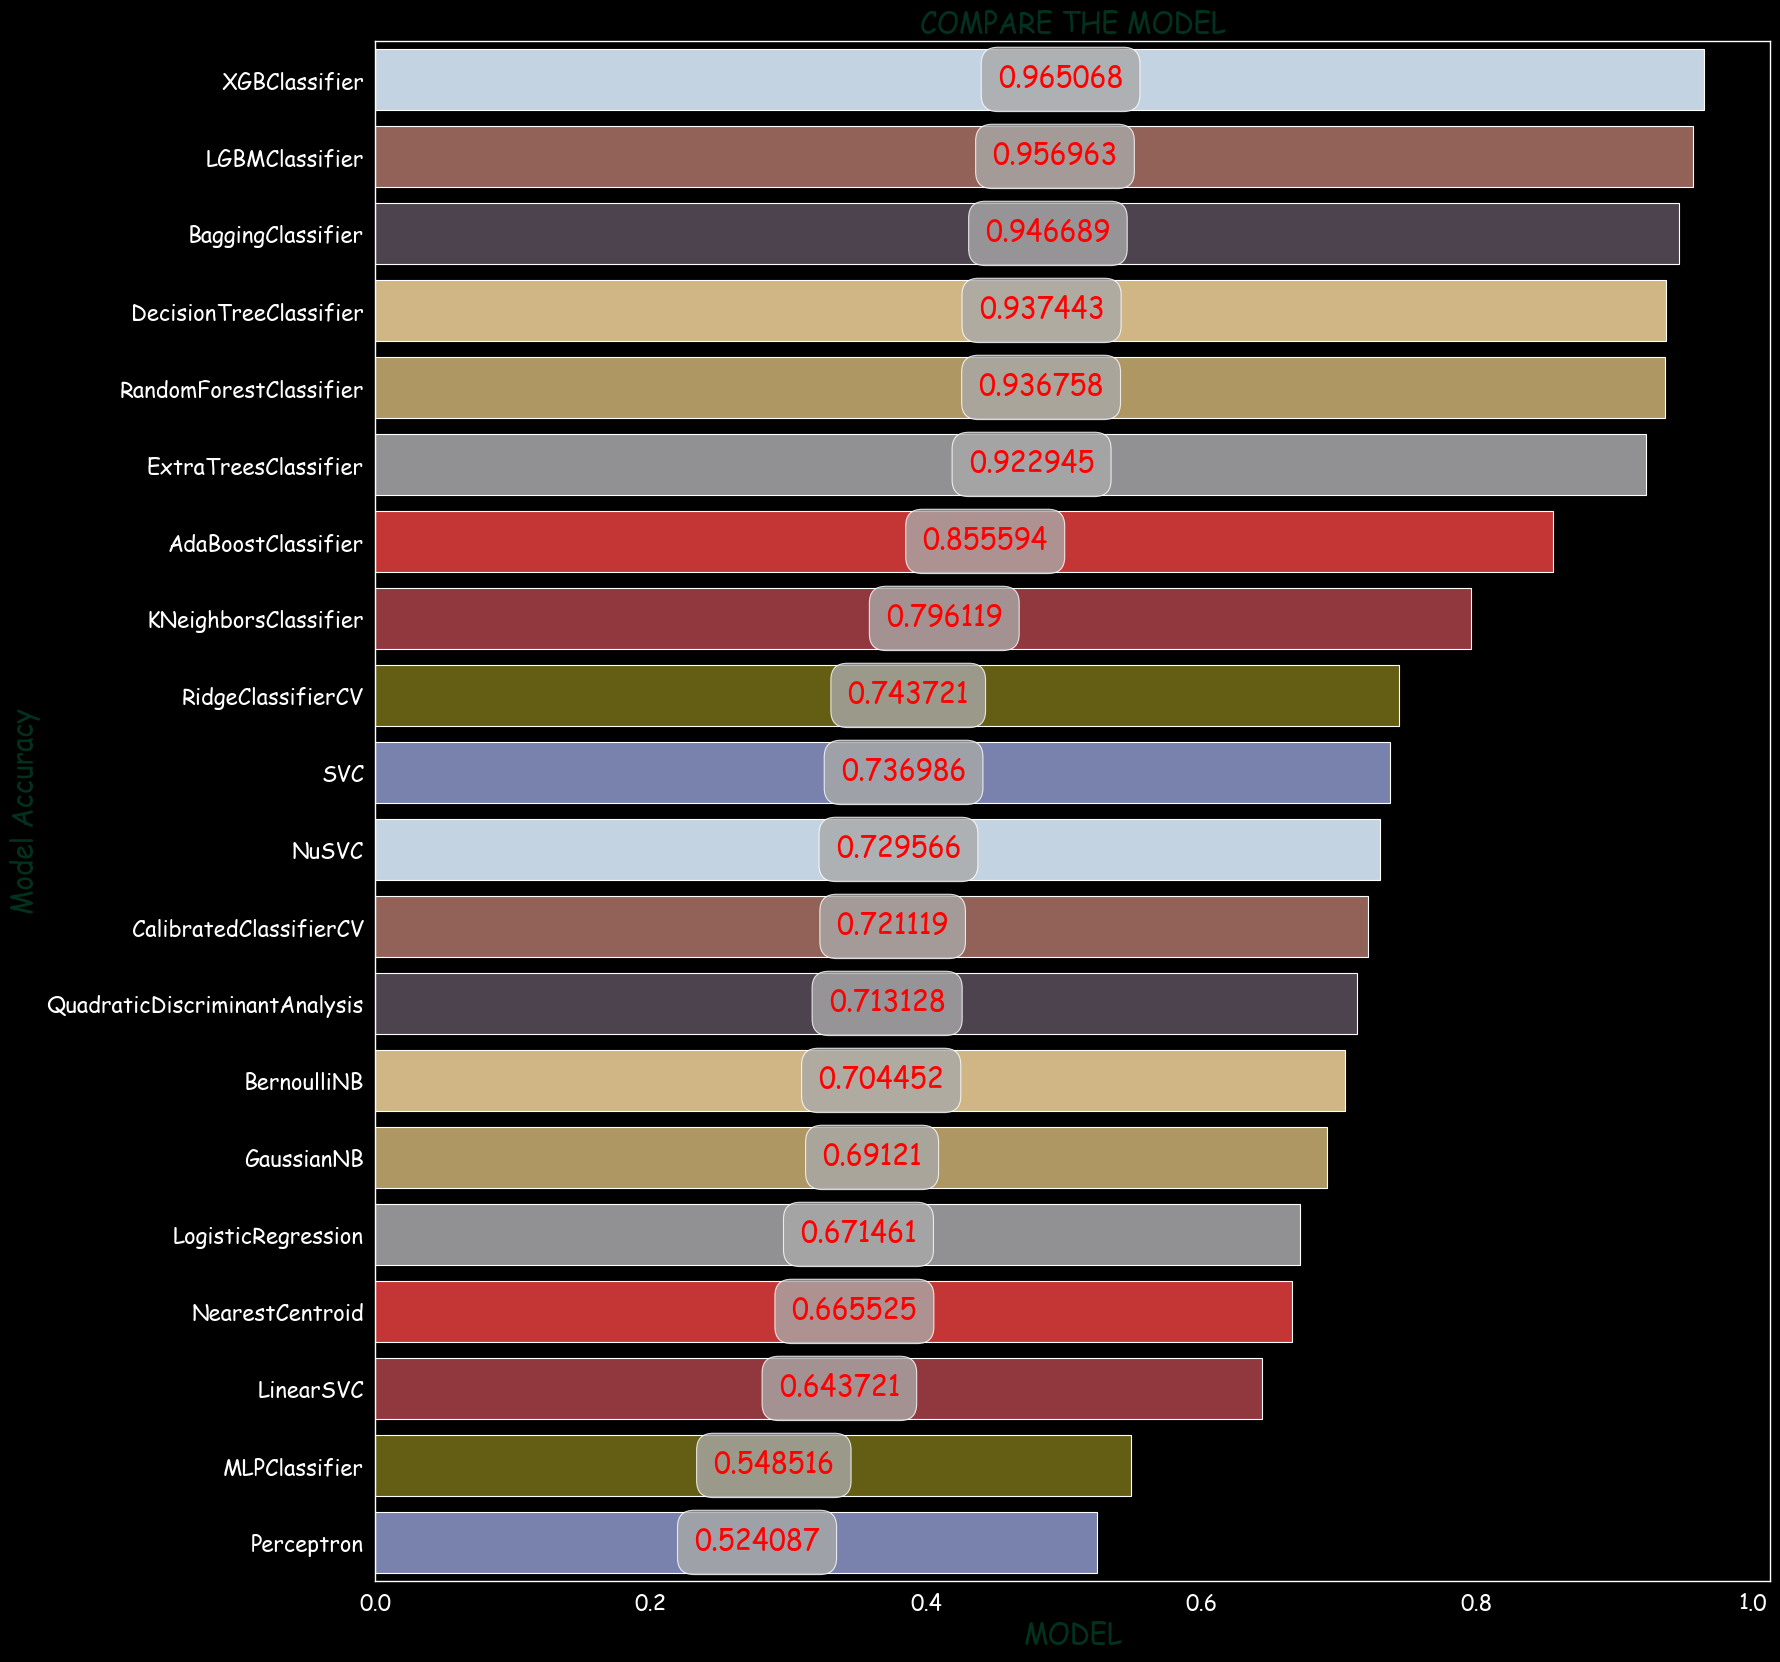

In [34]:
p = plt.figure(figsize=(18,20))
p = sns.set_context('paper', font_scale=1.8)

p = final_scores=final_scores.sort_values(by='Accuracy',ascending=False)[:20]

p = sns.barplot(y= 'Classifier', x= 'Accuracy', data= final_scores,palette=colors[0:10])

for container in p.containers:
    p.bar_label(container,label_type = 'center',padding = 15,size = 20,color = "Red",rotation = 0,
    bbox={"boxstyle": "round", "pad": 0.6, "facecolor": "#a9a9a9", "edgecolor": "white", "alpha": .8})

plt.title('COMPARE THE MODEL',fontsize=20,color='#013220')
plt.xlabel('MODEL',fontsize=20,color='#013220')
plt.ylabel('Model Accuracy',fontsize=20,color='#013220');